In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

TENSORFLOW = False

if TENSORFLOW:
    # TensorFlow ≥2.0 is required
    import tensorflow as tf
    assert tf.__version__ >= "2.0"

    if not tf.config.list_physical_devices('GPU'):
        print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
        
else:
    # Torch ≥1.4.0 is required
    import torch 
    assert torch.__version__ >= "1.4.0"

    if torch.cuda.is_available():
        print('GPU support (%s)' % torch.cuda.get_device_name(0))
    else:
        print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

GPU support (GeForce RTX 2080)
cuda:0


In [2]:
import os
import sys
import copy
from datetime import datetime
from pathlib import Path
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import argmax
import pandas as pd

if TENSORFLOW:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.python.keras import backend as K # beware of .python. here
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (BatchNormalization, Conv1D, Conv2D, Dense, 
                                         Flatten, Input, TimeDistributed, Activation, 
                                         Bidirectional, SimpleRNN, GRU, LSTM, Reshape)
    from tensorflow.keras.layers import Lambda
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
else:
    import torch.nn as nn
    import torch.optim as optim

In [3]:
!pip -q install watermark
import watermark
%load_ext watermark
%watermark --iversions

seaborn    0.9.0
watermark  1.8.1
matplotlib 3.0.3
torch      1.4.0
pandas     0.25.1
numpy      1.17.4



In [4]:
df = pd.read_csv('fr_wiktionary_full.csv', sep='\t')
#df = pd.read_csv('fr_wiktionary_waves_r.csv', sep='\t')
#df = pd.read_csv('fr_wiktionary_waves.csv', sep='\t')
df = df.dropna()
df = df[df.Audio != '-']
df[df.Mot.str.startswith('a')].head()

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
39093,a,a,False,pronom personnel,[],True,-,-
39094,a,a,False,lettre,[],True,-,-
39095,a,ɑ,False,lettre,[],True,-,-
39096,a,a,False,verbe_flexion,[],True,-,-
39097,a beau mentir qui vient de loin,a bo mɑ̃.tiʁ ki vjɛ̃ də lwɛ̃,False,locution-phrase,[],False,err_too_many_spaces,6_spaces


In [5]:
PHONEMES = [
        # Voyelles
        'i','e','ɛ','a','ɑ','ɔ','o','u','y','ø','œ','ə','ɛ̃','ɑ̃','ɔ̃','œ̃',
        # Semi-consonnes
        'j','w','ɥ', 
        # Consonnes
        'p','t','k','b','d','ɡ','f','s','ʃ','v','z','ʒ','l','ʁ','m','n','ɲ','ŋ',
    ]
    
def print_phonemes():
    i = 0 
    for i in range(len(PHONEMES) + 2):
        if i == 0:
            print("' 0")
        elif i == 1:
            print('<SPACE> 1')
        else:
            print('%s %d' % (PHONEMES[i-2], i))

In [6]:
# Skip samples whose pronunciation contains unknown phonemes
df = df[~df['Prononciation'].isin(PHONEMES)]

In [7]:
df.shape

(1503368, 8)

In [8]:
df.Prononciation.str.len().max()

120

In [9]:
df[df.Mot=='tonton']

,Mot,Prononciation,H_aspiré,Type,Audio,Pré_valide,Warn_code,Warn_label
1391761,tonton,tɔ̃.tɔ̃,False,nom,[],True,-,-


In [10]:
char_map_str = """
' 0
<SPACE> 1
i 2
e 3
ɛ 4
a 5
ɑ 6
ɔ 7
o 8
u 9
y 10
ø 11
œ 12
ə 13
ɛ̃ 14
ɑ̃ 15
ɔ̃ 16
œ̃ 17
j 18
w 19
ɥ 20
p 21
t 22
k 23
b 24
d 25
ɡ 26
f 27
s 28
ʃ 29
v 30
z 31
ʒ 32
l 33
ʁ 34
m 35
n 36
ɲ 37
ŋ 38
"""

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

In [11]:
def get_phonemes(pronunciation):
    
    phonemes = []
    for i in range(len(pronunciation)):
        if i < len(pronunciation) - 1:
            if pronunciation[i]=='̃':
                continue
            if pronunciation[i+1]=='̃':
                if pronunciation[i] == 'ɑ':
                    phoneme = 'ɑ̃'
                elif pronunciation[i] == 'ɔ':
                    phoneme = 'ɔ̃'
                elif pronunciation[i] == 'œ':
                    phoneme = 'œ̃'
                elif pronunciation[i] == 'ɛ':
                    phoneme = 'ɛ̃'
                else:
                    print('can not happen c=%s' % c)
            else:
                phoneme = pronunciation[i]
        else:
            if pronunciation[i]=='̃':
                continue
            else: 
                phoneme = pronunciation[i]
        phonemes.append(phoneme)
    return phonemes

def get_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_phonemes(pronunciation)    
    # pad list of phonemes
    for i in range(len(padded_phonemes), str_len_max):
        padded_phonemes.append("'")
    return padded_phonemes

def get_tk_padded_phonemes(pronunciation, str_len_max):
    
    padded_phonemes = get_padded_phonemes(pronunciation, str_len_max)
    tk_padded_phonemes = []
    # tokenize each phoneme
    for phoneme in padded_phonemes:
        tk_padded_phonemes.append(char_map[phoneme])
    
    nb = len(padded_phonemes)
    np_array = np.array(tk_padded_phonemes).reshape(1, nb)
    
    return np_array
    
assert get_phonemes('tɛ̃bʁ') == ['t', 'ɛ̃', 'b', 'ʁ']
assert get_phonemes('tɔ̃tɔ̃') == ['t', 'ɔ̃', 't', 'ɔ̃']
assert get_padded_phonemes('tɛ̃bʁ', 6) == ['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]
assert np.array_equal(get_tk_padded_phonemes('tɛ̃bʁ', 6), np.array([[22, 14, 24, 34,  0,  0]]))

def get_prononciation(padded_phonemes):
    
    prononciation = ''
    for padded_phoneme in padded_phonemes:
        if padded_phoneme == "'":
            break
        else:
            prononciation += padded_phoneme

    return prononciation
assert get_prononciation(['t', 'ɛ̃', 'b', 'ʁ', "'", "'"]) == 'tɛ̃bʁ', 6

In [12]:
def get_string_to_numpy(string, nb_max_chars):
    
    if nb_max_chars < len(string):
        raise ValueError('must not happen: nb_max_chars:%d too smal for string:%s (%d letters)'
             % (nb_max_chars, string, len(string)))
        return ''
    
    np_string = np.zeros((nb_max_chars))
    for i in range(len(string)):
        np_string[i] = ord(string[i])
        
    return np_string

def get_string_from_numpy(np_string):
    
    string=''
    for i in range(np_string.shape[0]):
        code = int(np_string[i])
        if code == 0:
            break
        else:
            string += chr(code)
    return string


assert get_string_from_numpy(get_string_to_numpy("tɛ̃bʁ", 6)) == "tɛ̃bʁ"

In [13]:
def get_audio_files_names(audio_files_str, speakers=[], verbose=False):
    if verbose:
        print('audio_files=*%s*' % audio_files_str)
    if audio_files_str == '[]':
        if verbose:
            print('empty list')
        audio_file_names = []
    else:
        if audio_files_str.startswith('['):
            files_string = audio_files_str[2:-2]
        else:
            files_string = audio_files_str
        files_string += '\', \''
        audio_file_names = files_string.split('\', \'')
        audio_file_names = audio_file_names[:-1]
        audio_file_names2 = []
        for audio_file_name in audio_file_names:
            if len(speakers) == 0:
                audio_file_names2.append(audio_file_name)
            else:
                for speaker in speakers:         
                    if speaker in audio_file_name:
                        audio_file_names2.append(audio_file_name)
        audio_file_names = audio_file_names2        
        if verbose:
            for f in audio_file_names:
                print('file=%s' % f)
    return audio_file_names

assert get_audio_files_names("[]") == []
assert get_audio_files_names("['a.wav']") == ['a.wav']
assert get_audio_files_names("LL-Q150 (fra)-LoquaxFR-&amp;.wav") == ['LL-Q150 (fra)-LoquaxFR-&amp;.wav']
assert get_audio_files_names("['a.wav', 'b.wav', 'c.wav']") == ['a.wav', 'b.wav', 'c.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['foo']) == ['-foo-a.wav', '-foo-d.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['bar']) == ['-bar-b.wav']
assert get_audio_files_names("['-foo-a.wav', '-bar-b.wav', '-car-c.wav', '-foo-d.wav']", ['bar', 'foo']) == ['-foo-a.wav', '-bar-b.wav', '-foo-d.wav']

In [14]:
allowed_IPA_letters = [
            'a', 'b', 'd', 'e', 'f', 'i', 'j', 'k', 'l', 
            'm', 'n', 'o','p', 's', 't', 'u', 'v', 'w', 'y', 
            'z', 'ø', 'ŋ', 'œ', 'ɑ', 'ɔ', 'ə', 'ɛ', 'ɡ', 'ɥ',
            'ɲ', 'ʁ', 'ʃ', 'ʒ', '̃'   
]

''' Retrieve the dataset 
'''
def get_data(mfcc_dir, n_max=sys.maxsize, n_max_phonemes=sys.maxsize, 
             speakers=[], verbose=False, order=False, check_phonemes=True):    
    
    df = pd.read_csv('fr_wiktionary_waves.csv', sep='\t')
    df = df[df.Audio != '-']

    df = df[df.Prononciation.str.len() <= n_max_phonemes]
    print('df.shape:%d (with len(prononciation)<=%d)' % (df.shape[0], n_max_phonemes))
    
    # filter out samples from selected speakers, if any
    df0 = pd.DataFrame(columns=df.columns)
    if len(speakers) > 0:
        for speaker in speakers:
            df0 = pd.concat([df0, df[df['Audio'].str.contains(speaker)]])
        df = df0
    
    # reindex the dataframe by the Pronunciation column lenght
    if order:
        s = df.Prononciation.str.len().sort_values(ascending=True).index
        df = df.reindex(s)
    else:
        # reshuffle the index
        df = df.sample(frac=1).reset_index(drop=True)
    
    # clean pronunciation
    # rows having a pronnuciation with "bad" caracter will be dropped from the df
    if check_phonemes:
        indexes_to_drop = []
        bad_letters = {}   
        for index, row in df.iterrows():
            prononciation = row['Prononciation']
            prononciation = prononciation.replace('(','').replace(')','').replace('‿','').\
            replace('.','').replace(' ','').replace('͡','').replace('-','').replace('ˈ','').\
            replace('ː','').replace('r', 'ʁ')
            #prononciation = merge_nasals(prononciation)
            for phoneme in prononciation:            
                if phoneme not in allowed_IPA_letters:
                    if phoneme not in bad_letters.keys():
                        bad_letters[phoneme] = 0
                    bad_letters[phoneme] += 1
                    if verbose:
                        print('bad phoneme %s in [%s] /%s/' % (phoneme, row['Mot'], row['Prononciation']))
                    indexes_to_drop.append(index)
                    break
            df.at[index, 'Prononciation'] = prononciation            
        print('bad_letters=', bad_letters)
        df = df.drop(indexes_to_drop)
    
    # read 1 mfcc file to learn the maximum shape of the samples in the directory
    mfcc_shape_t = 0 #87
    mfcc_shape_d = 0 #40
    
    for index, row in df[df.Audio != '-'].iterrows():
       
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'])
        if verbose:
            print('Audio=*%s*' % row['Audio'])
        for wav_file in wav_files:
            if verbose:
                print('wav_file=*%s*' % wav_file)
            mfcc_file = wav_file.replace('.wav','.npy').replace(' ','_') 
            mfcc_filename = mfcc_dir + mfcc_file
            
            if os.path.exists(mfcc_filename):
                mfcc = np.load(mfcc_filename)
                mfcc_shape_t = max(mfcc_shape_t, mfcc.shape[1])
                mfcc_shape_d = mfcc.shape[0]
                break
            else:
                if verbose:
                    print('mfcc_file=*%s* not found !!!' % mfcc_file)
    if mfcc_shape_t == 0:
        print('mfcc_shape_t not found !!!' % mfcc_file)
        return 0
    
    # mfcc_shape_t=87 # if time==2.0
    # mfcc_shape_d=40 #
    print('mfcc_shape_t:%d', mfcc_shape_t)
    print('mfcc_shape_d:%d', mfcc_shape_d)
    
    n_max = df.shape[0]
    n_ok=0
    n_ko=0
    
    # numpy shapes to be ready to be used as inputs and targets
    mfccs = np.zeros((n_max, mfcc_shape_t, mfcc_shape_d))
    phonemess = np.zeros((n_max, n_max_phonemes))
    CHAR_MAX = 50
    motss = np.zeros((n_max, CHAR_MAX))
    prononciationss = np.zeros((n_max, CHAR_MAX))
    #mots = []
    #prononciations = []
    
    for index, row in df.sample(n_max).iterrows(): # sample() is used to shuffle data           
    #for index, row in df.iterrows(): # sample() is used to shuffle data           
        
        mfcc_file = ''
        wav_files = get_audio_files_names(row['Audio'], speakers=speakers)
        # so far, take only first file (to be enhanced!!!)
        mfcc_file = wav_files[0].replace('.wav','.npy').replace(' ','_')
        
        if mfcc_file == '':
            continue
        
        mfcc_filename = mfcc_dir + mfcc_file
        if os.path.exists(mfcc_filename):
            mfcc = np.load(mfcc_filename)
            if verbose:            
                print('mfcc.shape:', mfcc.shape)
            
            if mfcc[-1][-1] != 0.0:
                try:
                    if verbose:
                        print('pb for %s' % row['Mot'])
                except:
                    print('#')
                continue
            
            # add the mfcc in the mfccs table
            mfccs[n_ok,:,:] = mfcc.transpose()[:,:]
        
            # fetch the prononciation
            mot = row['Mot']
            prononciation = row['Prononciation']
            prononciation = prononciation.replace('(','').replace(')','').replace('‿','').\
            replace('.','').replace(' ','').replace('͡','').replace('-','').replace('ˈ','').\
            replace('ː','').replace('r', 'ʁ')
            
            phonemes = get_tk_padded_phonemes(prononciation, n_max_phonemes)
            
            # add the mfcc in the mfccs table
            phonemess[n_ok,:] = phonemes
            #mots.append(mot)
            #prononciations.append(prononciation)
            try :
                motss[n_ok:] = get_string_to_numpy(mot, CHAR_MAX)
                prononciationss[n_ok:] = get_string_to_numpy(prononciation, CHAR_MAX)
                n_ok += 1
                if n_ok > n_max - 1:
                    break
            except:
                print("error for mot=%s, mot or pronuciation is float!!!!!!!!!!!!!!!!!" % mot)
                n_ko += 1
        else:
            if verbose:
                print('file ko:', mfcc_file)
            n_ko += 1
            
    print('n_ok:',n_ok)
    print('n_ko:',n_ko)
    
    # delete unused rows
    mfccs = mfccs[:n_ok,:,:]
    phonemess = phonemess[:n_ok]
    prononciationss = prononciationss[:n_ok]
    motss = motss[:n_ok]
    
    print('mfccs.shape:', mfccs.shape)
    print('phonemess.shape:', phonemess.shape)
    print('prononciationss.shape:', prononciationss.shape)
    print('motss.shape:', motss.shape)
    #print('len(prononciations):', len(prononciations))
    #print('len(mots):', len(mots))
        
    return n_ok, mfccs, phonemess, prononciationss, motss

In [15]:
AUDIO_DIR = 'audio/'
TIME_MAX = 2.0
MFCC_FREQS = 40
#MFCC_FREQS = 90
MFCC_DIR = 'mfcc_' + str(TIME_MAX) + '_' + str(MFCC_FREQS) + '/'

TARGET_PHONEMES_MAX = 20
ORDER = False

NB_TEST_SAMPLES = 1000
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

#speakers = ['WikiLucas'] # 19545 mots => 90: n_tested:100, n_ok:60, n_ko:40
#speakers = ['Lepticed'] #6145 => n_tested:100, n_ok:51, n_ko:49
speakers = ['WikiLucas', 'Lepticed'] # 25690
#speakers = ['Lyokoï'] # 9039 mots => n_tested:100, n_ok:62, n_ko:38
speakers = ['WikiLucas', 'Lepticed','Lyokoï'] # 90 : n_ok:64, n_ko:36 , 40: n_ok:66, n_ko:34
#speakers = [] # 30000 mots => 40:n_ok:61, n_ko:39

print('TARGET_PHONEMES_MAX:', TARGET_PHONEMES_MAX)
print('ORDER:', ORDER)

t0 = datetime.now()
n, mfccs, phonemes, prononciations, mots = get_data(mfcc_dir = MFCC_DIR, 
                                                    n_max=30000,
                                                    n_max_phonemes=TARGET_PHONEMES_MAX,
                                                    speakers = speakers, 
                                                    order=ORDER)
t1 = datetime.now()
data_import_duration = t1 - t0
print('data_import_duration', data_import_duration)

NB_TEST_SAMPLES:1000
TARGET_PHONEMES_MAX: 20
ORDER: False
df.shape:58761 (with len(prononciation)<=20)
bad_letters= {'ε': 2, '/': 1, 'h': 12, '·': 7, 'ʔ': 6, '̥': 3, 'ˌ': 1, 'ɪ': 5, 'ʊ': 1, ',': 2, '̯': 2, '…': 3, 'ᵊ': 2, 'ɒ': 1, 'ʰ': 1, '̩': 1, 'ʌ': 1, 'ʀ': 1, 'x': 1}
mfcc_shape_t:%d 87
mfcc_shape_d:%d 40
n_ok: 34729
n_ko: 54
mfccs.shape: (34729, 87, 40)
phonemess.shape: (34729, 20)
prononciationss.shape: (34729, 50)
motss.shape: (34729, 50)
data_import_duration 0:00:53.311932


In [16]:
phonemes.shape

(34729, 20)

In [17]:
mfccs.shape

(34729, 87, 40)

In [18]:
type(mfccs[0,0,0])

numpy.float64

In [19]:
n_wished_test = NB_TEST_SAMPLES
n_wished_train = n - n_wished_test
n_train_ratio = int(n_wished_train/n_wished_test)
print('n_train_ratio:%d',n_train_ratio)

# following code is somehow complex "just" to have the option to 
# preserve increased-length order in both the training and
# tests data.

# delete 1 row every n_train_ratio rows
mfccs_train = np.delete(mfccs, list(range(0, mfccs.shape[0], n_train_ratio)), axis=0)
phonemes_train = np.delete(phonemes, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
prononciations_train = np.delete(prononciations, list(range(0, phonemes.shape[0], n_train_ratio)), axis=0)
mots_train = np.delete(mots, list(range(0, mots.shape[0], n_train_ratio)), axis=0)
X_train = mfccs_train
Y_train = phonemes_train

# keep 1 row every n_train_ratio
mfccs_test = mfccs[0::n_train_ratio]
phonemes_test = phonemes[0::n_train_ratio]
prononciations_test= prononciations[0::n_train_ratio]
mots_test = mots[0::n_train_ratio]
X_test = mfccs_test
Y_test = phonemes_test

n_train_ratio:%d 33


In [20]:
# get ride of few samples in order to respect the number of
# wanted test samples (e.g. decimal "round" number like 100)
# which will allow for direct estimation of percentages.
if mfccs_test.shape[0] - NB_TEST_SAMPLES > 0:
    mfccs_test = mfccs_test[0:NB_TEST_SAMPLES]
    phonemes_test = phonemes_test[0:NB_TEST_SAMPLES]
    mots_test = mots_test[0:NB_TEST_SAMPLES]
    X_test = mfccs_test
    Y_test = phonemes_test
NB_TRAINING_SAMPLES = X_train.shape[0]
print('NB_TRAINING_SAMPLES:%d' % NB_TRAINING_SAMPLES)
print('NB_TEST_SAMPLES:%d' % NB_TEST_SAMPLES)

NB_TRAINING_SAMPLES:33676
NB_TEST_SAMPLES:1000


In [21]:
x_train_mean = X_train.mean()
x_train_std = X_train.std()
X_train -= x_train_mean
X_train /= x_train_std

In [22]:
X_test -= x_train_mean
X_test /= x_train_std

In [23]:
# Define the model
class CNN(nn.Module):
  def __init__(self, D, max_string_len, C, T):
    super(CNN, self).__init__()
    #self.V = n_vocab
    self.D = D
    self.K = C
    self.max_string_len = max_string_len
    self.T = T
    self.first_time = True

    
    #torch.nn.Conv1d(in_channels, out_channels, kernel_size, 
    #                stride=1, padding=0, dilation=1, groups=1, 
    #                bias=True, padding_mode='zeros')
    self.conv1 = nn.Conv1d(self.D, 128, 3, stride=1, padding=1) 
    #self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(128, 256, 3, stride=1, padding=1)
    #self.pool2 = nn.MaxPool1d(2)
    #self.conv3 = nn.Conv1d(256, 512, 3, stride=1, padding=1)    
    
    self.lstm = nn.LSTM(input_size=256, hidden_size=256, num_layers=2,
                        dropout=0.5, bidirectional=True, 
                        batch_first=True,
                       )
    
    self.fc = nn.Linear(512, self.K)
    
    self.bn1 = nn.BatchNorm1d(128)
    self.bn2 = nn.BatchNorm1d(256)
    self.bn3 = nn.BatchNorm1d(self.T)
    
  
  def forward(self, X, verbose=True):
        
    global FIRST_TIME
    # embedding layer
    # turns word indexes into word vectors
    data = X

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    if verbose and self.first_time:
        print('before permute data.shape:',data.shape)    
    data = data.permute(0, 2, 1)
    
    if verbose and self.first_time:
        print('before conv1 data.shape:',data.shape)
    data = self.conv1(data)
    data = self.bn1(data)
    
    if verbose and self.first_time:
        print('before relu1 data.shape:',data.shape)
    data = torch.relu(data)
    #data = self.pool1(data)
    if verbose and self.first_time:
        print('before conv2 data.shape:',data.shape)
    data = self.conv2(data)
    data = self.bn2(data)
    
    if verbose and self.first_time:
        print('before relu2 data.shape:',data.shape)
    data = torch.relu(data)
    #data = self.pool2(data)
    #if verbose and self.first_time:
    #    print('before conv3 data.shape:',data.shape)
    #data = self.conv3(data)
    #if verbose and self.first_time:
    #    print('before relu3 data.shape:',data.shape)
    #data = nn.functional.relu(data)
    
    #if verbose:
    #    print('before view data.shape:',data.shape)
    #data = data.view(-1, 87, 32) #XM
    
    if verbose and self.first_time:
        print('before permute data.shape:', data.shape)    
    data = data.permute(0, 2, 1)

    if verbose and self.first_time:
        print('before bi-lstm data.shape:',data.shape)
    data, states = self.lstm(data)
    
    data = self.bn3(data)
    
    # max pool
    #out, _ = torch.max(out, self.K)
    if verbose and self.first_time:
        print('before fc data.shape::', data.shape, '\n')
    # final dense layer
    data = self.fc(data)
    
    if verbose and self.first_time:
        print('after fc data.shape::', data.shape, '\n')
    
    self.first_time = False
    
    return data

#before permute data.shape: torch.Size([32, 128, 87])
#before fc data.shape:: torch.Size([32, 87, 128]) 

In [24]:
# outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
#input_length = X_train.shape[1]
#print('input_length', input_length)

print('X_train.shape', X_train.shape)
print('Y_train.shape', Y_train.shape)
      
N = NB_TRAINING_SAMPLES
print('N:%d (Number of samples)', N)
T = mfccs.shape[1]
print('T:%d (Time units)', T)

assert mfccs.shape[2] == MFCC_FREQS
D = mfccs.shape[2]
print('D:%d (Data units (frequency samples))', D)

input_length = np.zeros([N])
for i in range(N):
    input_length[i] = 87
print('input_length[0:2]:', input_length[0:2])
print('input_length.shape', input_length.shape)

label_length = np.zeros([N])
for i in range(N):
    label_length[i] = TARGET_PHONEMES_MAX
print('label_length[0:2]:', label_length[0:2])

#print('input_length.shape', input_length.shape)

loss = np.zeros([N])

print('loss.shape[0:2]', loss.shape[0:2])


C = len(char_map.keys()) + 1
print('C=%d (Classes units (IPA char samples)' % C)

X_train.shape (33676, 87, 40)
Y_train.shape (33676, 20)
N:%d (Number of samples) 33676
T:%d (Time units) 87
D:%d (Data units (frequency samples)) 40
input_length[0:2]: [87. 87.]
input_length.shape (33676,)
label_length[0:2]: [20. 20.]
loss.shape[0:2] (33676,)
C=40 (Classes units (IPA char samples)


In [25]:
#model = CNN(len(vocab), 20, 1)
model = CNN(D, TARGET_PHONEMES_MAX, C, T)
model.to(device)

CNN(
  (conv1): Conv1d(40, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=40, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(87, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [26]:
#import nn.CrossEntropyLoss
# Loss and optimizer
criterion = nn.CTCLoss(blank=1).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [27]:
# A function to encapsulate the training loop
def fit(model, criterion, optimizer, 
        X_train, Y_train, input_lenghts1, target_lenghts1, 
        X_test, Y_test, input_lenghts2, target_lenghts2, 
        epochs=10, verbose=False):
    
    if verbose:
        print('X_train.shape: ', X_train.shape)        
        print('Y_train.shape: ', Y_train.shape)
        print('input_lenghts1.shape: ', input_lenghts1.shape)
        print('target_lenghts1.shape: ', target_lenghts1.shape)
        print('X_test.shape: ', X_test.shape)        
        print('Y_test.shape: ', Y_test.shape)
        print('input_lenghts2.shape: ', input_lenghts2.shape)
        print('target_lenghts2.shape: ', target_lenghts2.shape)
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    test_loss_min = 1.0
    it_min = 0
    patience = 0
    patience_max = 10
    
    for it in range(epochs):
        #print('it:', it)
        t0 = datetime.now()
        train_loss = []

        for b in range(int(X_train.shape[0]/32)):
            #for inputs, targets in train_iter:
            #print('['+str(b*32)+':'+str((b+1)*32)+']')
            
            inputs = torch.from_numpy(X_train[b*32:(b+1)*32,:,:]).float()
            #print('inputs shape:',inputs.shape)
            targets = torch.from_numpy(Y_train[b*32:(b+1)*32,:]).float()
            input_lenghts = input_lenghts1[b*32:(b+1)*32]
            #print('input_lenghts shape:',input_lenghts.shape)
            target_lenghts = target_lenghts1[b*32:(b+1)*32]
      
            #print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
            #targets = targets.view(-1, 1).float()
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass !!!!!!!!!!!!
            outputs = model(inputs)
 
            probs = nn.functional.log_softmax(outputs, dim=2)
            probs = probs.transpose(0, 1) # (time, batch, n_class)
            
            loss1 = criterion(probs, targets, input_lenghts, target_lenghts)
        
            # Backward and optimize
            loss1.backward()
            optimizer.step()

            train_loss.append(loss1.item())
        
        #print("it:",it," training done")
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        test_loss = []
        #for inputs, targets in test_iter:
        for b in range(1):
            inputs = torch.from_numpy(X_test[b*32:(b+1)*32,:,:]).float()
            targets = torch.from_numpy(Y_test[b*32:(b+1)*32,:]).float()
            inputs, targets = inputs.to(device), targets.to(device)
            input_lenghts = input_lenghts2[b*32:(b+1)*32]
            target_lenghts = target_lenghts2[b*32:(b+1)*32]
      
            #targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            probs = nn.functional.log_softmax(outputs, dim=2)
            probs = probs.transpose(0, 1) # (time, batch, n_class)
            loss2 = criterion(probs, targets, input_lenghts, target_lenghts)
            test_loss.append(loss2.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        #print('test ok')
    
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

        if it==0:
            test_loss_min = test_loss
            torch.save(model, 'wav2phoneme_pytorch.torch')
            #print('INIT test_loss_min:%f', test_loss_min)
        elif test_loss < test_loss_min:
            test_loss_min = test_loss
            torch.save(model, 'wav2phoneme_pytorch.torch')
            print('NEW BEST Test Loss:%.2f' % test_loss_min)
            i_min = i
            patience = 0
        else:
            #print('(old) test_loss_min:%f', test_loss_min)
            patience += 1
            if patience == patience_max:
                print('Patience max reached, break')
                print('Restaure best !')
                model = torch.load('wav2phoneme_pytorch.torch')
                break
                
            
    return model, train_losses[0:it+1], test_losses[0:it+1]

In [28]:
Y_test.shape

(1000, 20)

In [29]:
N_train = int(X_train.shape[0] * 0.9)
N_test = X_train.shape[0] - N_train
X_train1 = X_train[0:N_train]
Y_train1 = Y_train[0:N_train]
input_lenghts_train1 = torch.from_numpy(input_length[0:N_train]).short()
target_lenghts_train1 = torch.from_numpy(label_length[0:N_train]).short()
X_train2 = X_train[N_train:]
Y_train2 = Y_train[N_train:]
input_lenghts_train2= torch.from_numpy(input_length[N_train:]).short()
target_lenghts_train2 = torch.from_numpy(label_length[N_train:]).short()

In [30]:
t0 = datetime.now()

model, train_losses, test_losses = fit(model, criterion, optimizer, 
        X_train1, 
        Y_train1, 
        input_lenghts_train1, 
        target_lenghts_train1,
        X_train2, 
        Y_train2, 
        input_lenghts_train2, 
        target_lenghts_train2, 
        200)

t1 = datetime.now()
training_duration = t1 - t0
print('training_duration', training_duration)

before permute data.shape: torch.Size([32, 87, 40])
before conv1 data.shape: torch.Size([32, 40, 87])
before relu1 data.shape: torch.Size([32, 128, 87])
before conv2 data.shape: torch.Size([32, 128, 87])
before relu2 data.shape: torch.Size([32, 256, 87])
before permute data.shape: torch.Size([32, 256, 87])
before bi-lstm data.shape: torch.Size([32, 87, 256])
before fc data.shape:: torch.Size([32, 87, 512]) 

after fc data.shape:: torch.Size([32, 87, 40]) 

Epoch 1/200, Train Loss: 0.5664, Test Loss: 0.2745, Duration: 0:00:19.481445


/home/xavier/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2/200, Train Loss: 0.2359, Test Loss: 0.1897, Duration: 0:00:19.463287
NEW BEST Test Loss:0.19
Epoch 3/200, Train Loss: 0.1842, Test Loss: 0.1639, Duration: 0:00:19.627428
NEW BEST Test Loss:0.16
Epoch 4/200, Train Loss: 0.1574, Test Loss: 0.1395, Duration: 0:00:19.385418
NEW BEST Test Loss:0.14
Epoch 5/200, Train Loss: 0.1392, Test Loss: 0.1349, Duration: 0:00:19.278173
NEW BEST Test Loss:0.13
Epoch 6/200, Train Loss: 0.1234, Test Loss: 0.1233, Duration: 0:00:19.828324
NEW BEST Test Loss:0.12
Epoch 7/200, Train Loss: 0.1305, Test Loss: 0.1441, Duration: 0:00:19.842430
Epoch 8/200, Train Loss: 0.1185, Test Loss: 0.0969, Duration: 0:00:19.796857
NEW BEST Test Loss:0.10
Epoch 9/200, Train Loss: 0.1220, Test Loss: 0.1380, Duration: 0:00:19.618611
Epoch 10/200, Train Loss: 0.1074, Test Loss: 0.1094, Duration: 0:00:19.485696
Epoch 11/200, Train Loss: 0.0929, Test Loss: 0.1205, Duration: 0:00:19.514604
Epoch 12/200, Train Loss: 0.0968, Test Loss: 0.1136, Duration: 0:00:19.827848
Epoch 

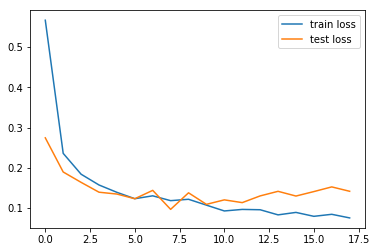

In [31]:
# Plot the train loss and test loss per iteration
_ = plt.plot(train_losses, label='train loss')
_ = plt.plot(test_losses, label='test loss')
_ = plt.legend()
_ = plt.show()

## Test 

In [32]:
def decode_predictions(output, labels, allow_consecutive=False, verbose=False):
    #print('output.shape:', output.shape)
    arg_maxes = torch.argmax(output, dim=2)
    #print('arg_maxes:',arg_maxes)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = ''
        target = ''
        previous_letter = '@'
        if verbose:
            print('i:',i)
            print('args:',args)
            print('labels[i]:',labels[i])
            print('labels[i][:label_lengths[i]]:', labels[i][:int(label_lengths[i])])
        
        for j, index_ in enumerate(labels[i]):
            index = index_.item()
            target_letter = index_map[index+1]
            if verbose:
                print('target_letter:%s' % target_letter)
            if target_letter != ' ' and target_letter !="'":
                target += target_letter
        
        if verbose:
            print('target:',target)
        targets.append(target)
        for j, index_ in enumerate(args):
            index = index_.item()
            predicted_letter = index_map[index+1]
            if verbose:
                print('letter:%s' % predicted_letter)
            if predicted_letter != ' ' and predicted_letter !="'" and predicted_letter != previous_letter:
                decode += predicted_letter
                previous_letter = predicted_letter
        if verbose:
            print("decoded:", decode)
        decodes.append(decode)
    return decodes, targets

In [33]:
from IPython.display import Markdown
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

inputs = torch.from_numpy(X_test[0:NB_TEST_SAMPLES]).float()
labels = torch.from_numpy(Y_test[0:NB_TEST_SAMPLES]).float()
inputs, targets = inputs.to(device), labels.to(device)
predicted = model(inputs)
phonemess, target_phonemess = decode_predictions(predicted, labels)

n_tested = 0
n_ok = 0
n_ko = 0

debug_str = '[MOT] /PRONONCIATION WIKTIONNAIRE/ vs /PRONONCIATION PREDITE/<br>'

targets = []
predictions = []

#NB_TEST_SAMPLES = 10
for i in range(NB_TEST_SAMPLES):
    phonemes = ''
    mot = get_string_from_numpy(mots_test[i])
    prononciation = get_string_from_numpy(prononciations_test[i])
    
    debug_str += '[' + mot + ']' + '/' + prononciation + '/ : '
    
    #prononciation = phonemes_test[i]
    phonemes = phonemess[i]
    target_phonemes = target_phonemess[i]
    debug_str += '/' + target_phonemes + '/ vs '
    
    targets.append(prononciation)
    predictions.append(phonemes)
    debug_str += '/' + phonemes + '/'
    n_tested += 1
    if phonemes == target_phonemes:
        debug_str += ': <span style="color: #00ff00">ok</span><br>'
        n_ok += 1
    else:
        debug_str += ': <span style="color: #ff0000">ko</span><br>'  
        n_ko += 1
display (Markdown(debug_str))
        
print('n_tested:%d, n_ok:%d, n_ko:%d' % (n_tested, n_ok, n_ko))

[MOT] /PRONONCIATION WIKTIONNAIRE/ vs /PRONONCIATION PREDITE/<br>[LIFO]/lifo/ : /lifo/ vs /lifo/: <span style="color: #00ff00">ok</span><br>[bioprospection]/bjɔpʁɔspɛksjɔ̃/ : /bjɔpʁɔspɛksjɔ̃/ vs /bjɔpʁɔspɛksjɔ̃/: <span style="color: #00ff00">ok</span><br>[regazer]/ʁəɡaze/ : /ʁəɡaze/ vs /ʁəɡaze/: <span style="color: #00ff00">ok</span><br>[ensacher]/ɑ̃saʃe/ : /ɑ̃saʃe/ vs /ɑ̃saʃe/: <span style="color: #00ff00">ok</span><br>[se dérougir]/sədeʁuʒiʁ/ : /sədeʁuʒiʁ/ vs /sədeʁuʒiʁ/: <span style="color: #00ff00">ok</span><br>[cyberdjihadisme]/sibɛʁdʒiadizm/ : /sibɛʁdʒiadizm/ vs /sibɛʁdjadism/: <span style="color: #ff0000">ko</span><br>[curryfication]/kyʁifikatjɔ̃/ : /kyʁifikatjɔ̃/ vs /kyʁifikasjɔ̃/: <span style="color: #ff0000">ko</span><br>[latifundiste]/latifœ̃dist/ : /latifœ̃dist/ vs /latifɛ̃dist/: <span style="color: #ff0000">ko</span><br>[détireuse]/detiʁøz/ : /detiʁøz/ vs /detiʁøz/: <span style="color: #00ff00">ok</span><br>[carniste]/kaʁnist/ : /kaʁnist/ vs /kaʁnist/: <span style="color: #00ff00">ok</span><br>[duelliste]/dɥɛlist/ : /dɥɛlist/ vs /dɥelist/: <span style="color: #ff0000">ko</span><br>[philosophaliste]/filozofalist/ : /filozofalist/ vs /filøzɔfalist/: <span style="color: #ff0000">ko</span><br>[féculiste]/fekylist/ : /fekylist/ vs /ʁekylist/: <span style="color: #ff0000">ko</span><br>[laidement]/lɛdmɑ̃/ : /lɛdmɑ̃/ vs /lɛdmɑ̃/: <span style="color: #00ff00">ok</span><br>[argotisme]/aʁɡɔtism/ : /aʁɡɔtism/ vs /aʁɡɔtism/: <span style="color: #00ff00">ok</span><br>[grécoliser]/ɡʁekɔlize/ : /ɡʁekɔlize/ vs /ɡʁekɔlize/: <span style="color: #00ff00">ok</span><br>[conjoints]/kɔ̃ʒwɛ̃/ : /kɔ̃ʒwɛ̃/ vs /kɔ̃ʒwɛ̃/: <span style="color: #00ff00">ok</span><br>[cyber-réputation]/sibɛʁʁepytasjɔ̃/ : /sibɛʁʁepytasjɔ̃/ vs /sibɛlabytasjɔ̃/: <span style="color: #ff0000">ko</span><br>[acidifiant]/asidifjɑ̃/ : /asidifjɑ̃/ vs /asidifjɑ̃/: <span style="color: #00ff00">ok</span><br>[antifranquiste]/ɑ̃tifʁɑ̃kist/ : /ɑ̃tifʁɑ̃kist/ vs /ɑ̃tifʁɑ̃kist/: <span style="color: #00ff00">ok</span><br>[repersiste]/ʁəpɛʁsist/ : /ʁəpɛʁsist/ vs /ʁəpɛʁsist/: <span style="color: #00ff00">ok</span><br>[incinérateur]/ɛ̃sinəʁatœʁ/ : /ɛ̃sinəʁatœʁ/ vs /ɛ̃sineʁatœʁ/: <span style="color: #ff0000">ko</span><br>[bistre]/bistʁ/ : /bistʁ/ vs /bistʁ/: <span style="color: #00ff00">ok</span><br>[dorgérisme]/dɔʁʒeʁism/ : /dɔʁʒeʁism/ vs /dɔʁʒeʁism/: <span style="color: #00ff00">ok</span><br>[compatible]/kɔ̃patibl/ : /kɔ̃patibl/ vs /kɔ̃patibl/: <span style="color: #00ff00">ok</span><br>[généreusement]/ʒeneʁøzmɑ̃/ : /ʒeneʁøzmɑ̃/ vs /ʒeneʁøzmɑ̃/: <span style="color: #00ff00">ok</span><br>[strafer]/stʁafe/ : /stʁafe/ vs /stʁafɛ/: <span style="color: #ff0000">ko</span><br>[déflegmation]/deflɛɡmasjɔ̃/ : /deflɛɡmasjɔ̃/ vs /defɛɡmasjɔ̃/: <span style="color: #ff0000">ko</span><br>[s’autoavilir]/sotoaviliʁ/ : /sotoaviliʁ/ vs /sotoaviliʁ/: <span style="color: #00ff00">ok</span><br>[tant mieux]/tɑ̃mjø/ : /tɑ̃mjø/ vs /pɑ̃mjø/: <span style="color: #ff0000">ko</span><br>[lynx roux]/lɛ̃ksʁu/ : /lɛ̃ksʁu/ vs /lɛ̃ksuʁo/: <span style="color: #ff0000">ko</span><br>[simpliste]/sɛ̃plist/ : /sɛ̃plist/ vs /sɛ̃plist/: <span style="color: #00ff00">ok</span><br>[billetophilie]/bijɛtɔfili/ : /bijɛtɔfili/ vs /bietɔfili/: <span style="color: #ff0000">ko</span><br>[cacou]/kaku/ : /kaku/ vs /kaku/: <span style="color: #00ff00">ok</span><br>[fortraniste]/fɔʁtʁanist/ : /fɔʁtʁanist/ vs /fɔʁtʁanist/: <span style="color: #00ff00">ok</span><br>[sous-graphe partiel]/suɡʁafpaʁsjɛl/ : /suɡʁafpaʁsjɛl/ vs /soɡʁafpaʁsjɛl/: <span style="color: #ff0000">ko</span><br>[turbo-capitalisme]/tyʁbɔkapitalism/ : /tyʁbɔkapitalism/ vs /tyʁbɔkapitalism/: <span style="color: #00ff00">ok</span><br>[éroder]/eʁɔde/ : /eʁɔde/ vs /eʁode/: <span style="color: #ff0000">ko</span><br>[sarceuse]/saʁsøz/ : /saʁsøz/ vs /saʁsøz/: <span style="color: #00ff00">ok</span><br>[passementer]/pasmɑ̃te/ : /pasmɑ̃te/ vs /pasmɑ̃te/: <span style="color: #00ff00">ok</span><br>[abandonneraient]/abɑ̃dɔnəʁɛ/ : /abɑ̃dɔnəʁɛ/ vs /abɑ̃dɔnəʁɛ/: <span style="color: #00ff00">ok</span><br>[abimé]/abime/ : /abime/ vs /adime/: <span style="color: #ff0000">ko</span><br>[cynologiste]/sinɔlɔʒist/ : /sinɔlɔʒist/ vs /sinɔlɔʒist/: <span style="color: #00ff00">ok</span><br>[renoncer]/ʁənɔ̃se/ : /ʁənɔ̃se/ vs /ʁənɔ̃se/: <span style="color: #00ff00">ok</span><br>[travaux dirigés]/tʁavodiʁiʒe/ : /tʁavodiʁiʒe/ vs /tʁavodiʁiʒe/: <span style="color: #00ff00">ok</span><br>[chercher chicane]/ʃɛʁʃeʃikan/ : /ʃɛʁʃeʃikan/ vs /ʃaʁʃeʃikan/: <span style="color: #ff0000">ko</span><br>[léonisme]/leɔnism/ : /leɔnism/ vs /leɔnism/: <span style="color: #00ff00">ok</span><br>[tailler les crayons]/tajelekʁɛjɔ̃/ : /tajelekʁɛjɔ̃/ vs /tɑjelekʁejɔ̃/: <span style="color: #ff0000">ko</span><br>[ajourner]/aʒuʁne/ : /aʒuʁne/ vs /aʒuʁne/: <span style="color: #00ff00">ok</span><br>[accommodant]/akɔmɔdɑ̃/ : /akɔmɔdɑ̃/ vs /akɔmɔdɑ̃/: <span style="color: #00ff00">ok</span><br>[pendant ce temps]/pɑ̃dɑ̃sətɑ̃/ : /pɑ̃dɑ̃sətɑ̃/ vs /pɑ̃stɑ̃/: <span style="color: #ff0000">ko</span><br>[décortication]/dekɔʁtikasjɔ̃/ : /dekɔʁtikasjɔ̃/ vs /dekɔʁtikasjɔ̃/: <span style="color: #00ff00">ok</span><br>[multicouple]/myltikupl/ : /myltikupl/ vs /myltikupk/: <span style="color: #ff0000">ko</span><br>[pêcher à la luminade]/peʃealalyminad/ : /peʃealalyminad/ vs /peʃealalyminad/: <span style="color: #00ff00">ok</span><br>[acquignicienne]/akiɲisjɛn/ : /akiɲisjɛn/ vs /aɡnmisjɛn/: <span style="color: #ff0000">ko</span><br>[faire des avances]/fɛʁdɛzavɑ̃s/ : /fɛʁdɛzavɑ̃s/ vs /fɛʁdezabɑ̃s/: <span style="color: #ff0000">ko</span><br>[inter-réagir]/ɛ̃tɛʁʁeaaʒiʁ/ : /ɛ̃tɛʁʁeaaʒiʁ/ vs /ɛ̃tɛʁʒeaʒiʁ/: <span style="color: #ff0000">ko</span><br>[fainéanter]/fɛneɑ̃te/ : /fɛneɑ̃te/ vs /feneɑ̃te/: <span style="color: #ff0000">ko</span><br>[misération]/mizeʁasjɔ̃/ : /mizeʁasjɔ̃/ vs /mizeʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[poinçonneuse]/pwɛ̃sɔnøz/ : /pwɛ̃sɔnøz/ vs /pwɛ̃sɔnøz/: <span style="color: #00ff00">ok</span><br>[celliste]/sɛlist/ : /sɛlist/ vs /selist/: <span style="color: #ff0000">ko</span><br>[inglorieusement]/ɛ̃ɡlɔʁjøzmɑ̃/ : /ɛ̃ɡlɔʁjøzmɑ̃/ vs /ɛ̃ɡyɔʁjøzmɑ̃/: <span style="color: #ff0000">ko</span><br>[se saouler]/səsule/ : /səsule/ vs /səsule/: <span style="color: #00ff00">ok</span><br>[juger sur l’étiquette]/ʒyʒesyʁletikɛt/ : /ʒyʒesyʁletikɛt/ vs /ʒyʒesyʁetikɛt/: <span style="color: #ff0000">ko</span><br>[chlorer]/klɔʁe/ : /klɔʁe/ vs /klɔʁe/: <span style="color: #00ff00">ok</span><br>[cachetonneur]/kaʃtɔnœʁ/ : /kaʃtɔnœʁ/ vs /kaʃtɔnœʁ/: <span style="color: #00ff00">ok</span><br>[console]/kɔ̃sɔl/ : /kɔ̃sɔl/ vs /kɔ̃sɔl/: <span style="color: #00ff00">ok</span><br>[inélastique]/inelastik/ : /inelastik/ vs /idelastik/: <span style="color: #ff0000">ko</span><br>[dibi]/dibi/ : /dibi/ vs /dibi/: <span style="color: #00ff00">ok</span><br>[bouffi]/bufi/ : /bufi/ vs /bufi/: <span style="color: #00ff00">ok</span><br>[parpeléger]/paʁpəleʒe/ : /paʁpəleʒe/ vs /paʁpəleʒe/: <span style="color: #00ff00">ok</span><br>[végétailler]/veʒetɑje/ : /veʒetɑje/ vs /veʒetɑje/: <span style="color: #00ff00">ok</span><br>[fouette cocher]/fwɛtkɔʃe/ : /fwɛtkɔʃe/ vs /fwadəkɔʃe/: <span style="color: #ff0000">ko</span><br>[capitalistiquement]/kapitalistikmɑ̃/ : /kapitalistikmɑ̃/ vs /kabitalistikmɑ̃/: <span style="color: #ff0000">ko</span><br>[incoercition]/ɛ̃koɛʁsisjɔ̃/ : /ɛ̃koɛʁsisjɔ̃/ vs /ɛ̃kɔɛʁtisjɔ̃/: <span style="color: #ff0000">ko</span><br>[schématisation]/ʃematizasjɔ̃/ : /ʃematizasjɔ̃/ vs /ʃematizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[décurie]/dekyʁi/ : /dekyʁi/ vs /dekyʁi/: <span style="color: #00ff00">ok</span><br>[ébahir]/ebaiʁ/ : /ebaiʁ/ vs /ebajiʁ/: <span style="color: #ff0000">ko</span><br>[Apricien]/apʁisjɛ̃/ : /apʁisjɛ̃/ vs /apʁisjɛ̃/: <span style="color: #00ff00">ok</span><br>[nigaudement]/niɡɔdmɑ̃/ : /niɡɔdmɑ̃/ vs /niɡɔdmɑ̃/: <span style="color: #00ff00">ok</span><br>[réaboutir]/ʁeabutiʁ/ : /ʁeabutiʁ/ vs /ʁeabutiʁ/: <span style="color: #00ff00">ok</span><br>[répétitivement]/ʁepetitivmɑ̃/ : /ʁepetitivmɑ̃/ vs /ʁepetitivmɑ̃/: <span style="color: #00ff00">ok</span><br>[abrogation]/abʁɔɡasjɔ̃/ : /abʁɔɡasjɔ̃/ vs /abʁɔɡasjɔ̃/: <span style="color: #00ff00">ok</span><br>[n’y voir goutte]/nivwaʁɡut/ : /nivwaʁɡut/ vs /ivwaʁɡut/: <span style="color: #ff0000">ko</span><br>[acting-out]/aktiŋaut/ : /aktiŋaut/ vs /aktiɲaɔt/: <span style="color: #ff0000">ko</span><br>[trimardeuse]/tʁimaʁdøz/ : /tʁimaʁdøz/ vs /tʁimaʁdøz/: <span style="color: #00ff00">ok</span><br>[immanentiste]/imanɑ̃tist/ : /imanɑ̃tist/ vs /imanɑ̃tist/: <span style="color: #00ff00">ok</span><br>[détesteur]/detɛstœʁ/ : /detɛstœʁ/ vs /detɛstœʁ/: <span style="color: #00ff00">ok</span><br>[décamper]/dekɑ̃pe/ : /dekɑ̃pe/ vs /dekɑ̃pe/: <span style="color: #00ff00">ok</span><br>[affaisser]/afese/ : /afese/ vs /afɛse/: <span style="color: #ff0000">ko</span><br>[être off]/ɛtʁɔf/ : /ɛtʁɔf/ vs /ɛpʁɔf/: <span style="color: #ff0000">ko</span><br>[prendre en filature]/pʁɑ̃dʁɑ̃filatyʁ/ : /pʁɑ̃dʁɑ̃filatyʁ/ vs /pʁɑ̃dʁɑ̃filatyʁ/: <span style="color: #00ff00">ok</span><br>[sanskritiste]/sɑ̃skʁitist/ : /sɑ̃skʁitist/ vs /sɑ̃skʁitist/: <span style="color: #00ff00">ok</span><br>[jérôme-boschisme]/ʒeʁombɔʃism/ : /ʒeʁombɔʃism/ vs /ʒeʁɔmbɔʃism/: <span style="color: #ff0000">ko</span><br>[métagénome]/metaʒenom/ : /metaʒenom/ vs /metaʒenom/: <span style="color: #00ff00">ok</span><br>[vedettisme]/vədɛtizm/ : /vədɛtizm/ vs /vɔdatism/: <span style="color: #ff0000">ko</span><br>[ouverture en fondu]/uvɛʁtyʁɑ̃fɔ̃dy/ : /uvɛʁtyʁɑ̃fɔ̃dy/ vs /uvɛʁtyʁɔ̃fudy/: <span style="color: #ff0000">ko</span><br>[carféral]/kaʁfeʁal/ : /kaʁfeʁal/ vs /kaʁtiʁal/: <span style="color: #ff0000">ko</span><br>[cafiste]/kafist/ : /kafist/ vs /kafist/: <span style="color: #00ff00">ok</span><br>[chimisme]/ʃimism/ : /ʃimism/ vs /ʃimism/: <span style="color: #00ff00">ok</span><br>[trembleuse]/tʁɑ̃bløz/ : /tʁɑ̃bløz/ vs /tʁɑ̃bløz/: <span style="color: #00ff00">ok</span><br>[abadassions]/abadasjɔ̃/ : /abadasjɔ̃/ vs /abadasjɔ̃/: <span style="color: #00ff00">ok</span><br>[grammatiste]/ɡʁamatist/ : /ɡʁamatist/ vs /ɡʁamatist/: <span style="color: #00ff00">ok</span><br>[recrasser]/ʁəkʁase/ : /ʁəkʁase/ vs /ʁəkʁase/: <span style="color: #00ff00">ok</span><br>[cuillère en bois]/kɥijɛʁɑ̃bwa/ : /kɥijɛʁɑ̃bwa/ vs /kɥijɛʁɑ̃bwa/: <span style="color: #00ff00">ok</span><br>[majorer]/maʒɔʁe/ : /maʒɔʁe/ vs /maʒɔʁe/: <span style="color: #00ff00">ok</span><br>[vers-libriste]/vɛʁlibʁist/ : /vɛʁlibʁist/ vs /vɛʁlibʁist/: <span style="color: #00ff00">ok</span><br>[ablation]/ablasjɔ̃/ : /ablasjɔ̃/ vs /aɡlasjɔ̃/: <span style="color: #ff0000">ko</span><br>[aigueardentier]/ɛɡaʁdɑ̃tje/ : /ɛɡaʁdɑ̃tje/ vs /eɡaʁdɑ̃tj/: <span style="color: #ff0000">ko</span><br>[agglutiner]/aɡlytine/ : /aɡlytine/ vs /aɡlytine/: <span style="color: #00ff00">ok</span><br>[attracteur]/atʁaktœʁ/ : /atʁaktœʁ/ vs /atʁaktœʁ/: <span style="color: #00ff00">ok</span><br>[maternalisme]/matɛʁnalism/ : /matɛʁnalism/ vs /mataʁnalism/: <span style="color: #ff0000">ko</span><br>[dégazer]/deɡaze/ : /deɡaze/ vs /deɡaze/: <span style="color: #00ff00">ok</span><br>[arrière-fleur]/aʁjɛʁflœʁ/ : /aʁjɛʁflœʁ/ vs /aʁjɛʁflœ/: <span style="color: #ff0000">ko</span><br>[cabrer]/kɑbʁe/ : /kɑbʁe/ vs /kɑbʁe/: <span style="color: #00ff00">ok</span><br>[frencher]/fʁɛntʃe/ : /fʁɛntʃe/ vs /fʁɛnʃe/: <span style="color: #ff0000">ko</span><br>[pouf]/puf/ : /puf/ vs /puf/: <span style="color: #00ff00">ok</span><br>[wikitraqueriez]/wikitʁakəʁje/ : /wikitʁakəʁje/ vs /wikitʁakəʁje/: <span style="color: #00ff00">ok</span><br>[dénommer]/denɔme/ : /denɔme/ vs /denɔme/: <span style="color: #00ff00">ok</span><br>[monnayer]/mɔneje/ : /mɔneje/ vs /mɔneje/: <span style="color: #00ff00">ok</span><br>[reradoter]/ʁəʁadɔte/ : /ʁəʁadɔte/ vs /ʁəʁadɔte/: <span style="color: #00ff00">ok</span><br>[offreuse]/ɔfʁøz/ : /ɔfʁøz/ vs /ɔfʁøz/: <span style="color: #00ff00">ok</span><br>[mauviette]/movjɛt/ : /movjɛt/ vs /mɔvjɛt/: <span style="color: #ff0000">ko</span><br>[retoper]/ʁətɔpe/ : /ʁətɔpe/ vs /ʁətɔpe/: <span style="color: #00ff00">ok</span><br>[théiste]/teist/ : /teist/ vs /teist/: <span style="color: #00ff00">ok</span><br>[rapace]/ʁapas/ : /ʁapas/ vs /ʁapas/: <span style="color: #00ff00">ok</span><br>[valoir mille]/valwaʁmil/ : /valwaʁmil/ vs /valwaʁmil/: <span style="color: #00ff00">ok</span><br>[réceptacle]/ʁesɛptakl/ : /ʁesɛptakl/ vs /ʁesɛptakl/: <span style="color: #00ff00">ok</span><br>[vin doux naturel]/vɛ̃dunatyʁɛl/ : /vɛ̃dunatyʁɛl/ vs /vɛ̃bunatyʁɛl/: <span style="color: #ff0000">ko</span><br>[romantiquement]/ʁɔmɑ̃tikmɑ̃/ : /ʁɔmɑ̃tikmɑ̃/ vs /ʁɔmɑ̃tikmɑ̃/: <span style="color: #00ff00">ok</span><br>[montrer qui c’est Raoul]/mɔ̃tʁekisɛʁaul/ : /mɔ̃tʁekisɛʁaul/ vs /mɔ̃tʁekiseʁaul/: <span style="color: #ff0000">ko</span><br>[chapugner]/ʃapyɲe/ : /ʃapyɲe/ vs /ʃapynje/: <span style="color: #ff0000">ko</span><br>[s’intravertir]/sɛ̃tʁavɛʁtiʁ/ : /sɛ̃tʁavɛʁtiʁ/ vs /sɛ̃pʁavɛʁtiʁ/: <span style="color: #ff0000">ko</span><br>[phéno-]/fenɔ/ : /fenɔ/ vs /feno/: <span style="color: #ff0000">ko</span><br>[œnolisme]/enɔlism/ : /enɔlism/ vs /enɔlism/: <span style="color: #00ff00">ok</span><br>[latte macchiato]/latemakjato/ : /latemakjato/ vs /latemapʃato/: <span style="color: #ff0000">ko</span><br>[buxidanicophile]/byksidanikɔfil/ : /byksidanikɔfil/ vs /byksidanikɔfil/: <span style="color: #00ff00">ok</span><br>[réenchérir]/ʁeɑ̃ʃeʁiʁ/ : /ʁeɑ̃ʃeʁiʁ/ vs /ʁeɑ̃ʃeʁiʁ/: <span style="color: #00ff00">ok</span><br>[draveuse]/dʁavøz/ : /dʁavøz/ vs /dʁavøz/: <span style="color: #00ff00">ok</span><br>[remongoliser]/ʁəmɔ̃ɡɔlize/ : /ʁəmɔ̃ɡɔlize/ vs /ʁəmɔ̃ɡɔlize/: <span style="color: #00ff00">ok</span><br>[cyclopéen]/siklɔpeɛ̃/ : /siklɔpeɛ̃/ vs /siklɔpeɛ̃/: <span style="color: #00ff00">ok</span><br>[idéalement]/idealmɑ̃/ : /idealmɑ̃/ vs /idalmɑ̃/: <span style="color: #ff0000">ko</span><br>[crampser]/kʁɑ̃pse/ : /kʁɑ̃pse/ vs /kʁɑ̃pse/: <span style="color: #00ff00">ok</span><br>[meneuse]/mənøz/ : /mənøz/ vs /mənøz/: <span style="color: #00ff00">ok</span><br>[exsufflation]/ɛksyflasjɔ̃/ : /ɛksyflasjɔ̃/ vs /ɛksyflasjɔ̃/: <span style="color: #00ff00">ok</span><br>[épluche-légume]/eplyʃleɡym/ : /eplyʃleɡym/ vs /eplyʃeɡym/: <span style="color: #ff0000">ko</span><br>[élever la voix]/elvelavwa/ : /elvelavwa/ vs /elvelavwa/: <span style="color: #00ff00">ok</span><br>[séquestrer]/sekɛstʁe/ : /sekɛstʁe/ vs /sekɛstʁe/: <span style="color: #00ff00">ok</span><br>[graphe symétrique]/ɡʁafsimetʁik/ : /ɡʁafsimetʁik/ vs /ɡʁafsimetʁik/: <span style="color: #00ff00">ok</span><br>[ultimement]/yltimmɑ̃/ : /yltimmɑ̃/ vs /yltiməmɑ̃/: <span style="color: #ff0000">ko</span><br>[rediner]/ʁədine/ : /ʁədine/ vs /ʁədine/: <span style="color: #00ff00">ok</span><br>[novelliste]/nɔvelist/ : /nɔvelist/ vs /nɔvɛlist/: <span style="color: #ff0000">ko</span><br>[exfœtation]/ɛksfetasjɔ̃/ : /ɛksfetasjɔ̃/ vs /ɛksfetasjɔ̃/: <span style="color: #00ff00">ok</span><br>[acromégale]/akʁɔmeɡal/ : /akʁɔmeɡal/ vs /akʁɔmeɡal/: <span style="color: #00ff00">ok</span><br>[c’est parti mon kiki]/sɛpaʁtimɔ̃kiki/ : /sɛpaʁtimɔ̃kiki/ vs /sepaʁtimɔkiki/: <span style="color: #ff0000">ko</span><br>[saint-frusquin]/sɛ̃fʁyskɛ̃/ : /sɛ̃fʁyskɛ̃/ vs /sɛ̃fʁyskɛ̃/: <span style="color: #00ff00">ok</span><br>[froncer]/fʁɔ̃se/ : /fʁɔ̃se/ vs /fʁɔ̃se/: <span style="color: #00ff00">ok</span><br>[impressionner]/ɛ̃pʁesjɔne/ : /ɛ̃pʁesjɔne/ vs /ɛ̃pʁɛsjɔne/: <span style="color: #ff0000">ko</span><br>[co-enseigner]/koɑ̃seɲe/ : /koɑ̃seɲe/ vs /koɑ̃seje/: <span style="color: #ff0000">ko</span><br>[intégrisme]/ɛ̃teɡʁism/ : /ɛ̃teɡʁism/ vs /ɛ̃teɡʁism/: <span style="color: #00ff00">ok</span><br>[végéter]/veʒete/ : /veʒete/ vs /veʒete/: <span style="color: #00ff00">ok</span><br>[Couronne australe]/kuʁɔnostʁal/ : /kuʁɔnostʁal/ vs /kuʁɔnɔstʁal/: <span style="color: #ff0000">ko</span><br>[châtier]/ʃɑtje/ : /ʃɑtje/ vs /ʃatje/: <span style="color: #ff0000">ko</span><br>[basisme]/bazism/ : /bazism/ vs /bazism/: <span style="color: #00ff00">ok</span><br>[parémiographe]/paʁemjɔɡʁaf/ : /paʁemjɔɡʁaf/ vs /paʁɛmjɔɡʁaf/: <span style="color: #ff0000">ko</span><br>[surévaluation]/syʁevalɥasjɔ̃/ : /syʁevalɥasjɔ̃/ vs /syʁevalɥasjɔ̃/: <span style="color: #00ff00">ok</span><br>[pépé]/pepe/ : /pepe/ vs /pepe/: <span style="color: #00ff00">ok</span><br>[émétophobie]/emetɔfɔbi/ : /emetɔfɔbi/ vs /emetɔfɔbi/: <span style="color: #00ff00">ok</span><br>[contestation]/kɔ̃tɛstasjɔ̃/ : /kɔ̃tɛstasjɔ̃/ vs /kɔ̃tɛstasjɔ̃/: <span style="color: #00ff00">ok</span><br>[abade]/abad/ : /abad/ vs /abad/: <span style="color: #00ff00">ok</span><br>[vêler]/vele/ : /vele/ vs /vele/: <span style="color: #00ff00">ok</span><br>[chaudron]/ʃodʁɔ̃/ : /ʃodʁɔ̃/ vs /ʃodʁɔ̃/: <span style="color: #00ff00">ok</span><br>[chronométrier]/kʁɔnɔmetʁje/ : /kʁɔnɔmetʁje/ vs /kʁɔnɔmetʁje/: <span style="color: #00ff00">ok</span><br>[incinération]/ɛ̃sineʁasjɔ̃/ : /ɛ̃sineʁasjɔ̃/ vs /ɛ̃sineʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[néphaliste]/nefalist/ : /nefalist/ vs /nefalist/: <span style="color: #00ff00">ok</span><br>[esse]/ɛs/ : /ɛs/ vs /ɛs/: <span style="color: #00ff00">ok</span><br>[inégalement]/ineɡalmɑ̃/ : /ineɡalmɑ̃/ vs /ineɡalmɑ̃/: <span style="color: #00ff00">ok</span><br>[rimasser]/ʁimase/ : /ʁimase/ vs /ʁimase/: <span style="color: #00ff00">ok</span><br>[voyer]/vwaje/ : /vwaje/ vs /vwaje/: <span style="color: #00ff00">ok</span><br>[recopuler]/ʁəkopyle/ : /ʁəkopyle/ vs /ʁəkɔpyle/: <span style="color: #ff0000">ko</span><br>[autocomplaisance]/otɔkɔ̃plezɑ̃s/ : /otɔkɔ̃plezɑ̃s/ vs /otokɔ̃plɛzɑ̃s/: <span style="color: #ff0000">ko</span><br>[anti-franquisme]/ɑ̃tifʁɑ̃kism/ : /ɑ̃tifʁɑ̃kism/ vs /ɑ̃tifʁɑ̃kism/: <span style="color: #00ff00">ok</span><br>[rétropolation]/ʁetʁopɔlasjɔ̃/ : /ʁetʁopɔlasjɔ̃/ vs /ʁetʁɔpɔlasjɔ̃/: <span style="color: #ff0000">ko</span><br>[çoufiste]/sufist/ : /sufist/ vs /sufist/: <span style="color: #00ff00">ok</span><br>[socier]/sɔsje/ : /sɔsje/ vs /sɔsje/: <span style="color: #00ff00">ok</span><br>[technophobie]/tɛknɔfɔbi/ : /tɛknɔfɔbi/ vs /tɛknɔfɔbi/: <span style="color: #00ff00">ok</span><br>[frériste]/fʁeʁist/ : /fʁeʁist/ vs /fʁeʁist/: <span style="color: #00ff00">ok</span><br>[bourriner]/buʁine/ : /buʁine/ vs /buʁine/: <span style="color: #00ff00">ok</span><br>[franco-centrisme]/fʁɑ̃kɔsɑ̃tʁism/ : /fʁɑ̃kɔsɑ̃tʁism/ vs /fʁɑ̃kɔsɑ̃tʁism/: <span style="color: #00ff00">ok</span><br>[envoyer des piques]/ɑ̃vwajedepik/ : /ɑ̃vwajedepik/ vs /ɑ̃vwajedepik/: <span style="color: #00ff00">ok</span><br>[rifagner]/ʁifaɲe/ : /ʁifaɲe/ vs /ʁifaɲe/: <span style="color: #00ff00">ok</span><br>[kakemphaton]/kakɑ̃fatɔ̃/ : /kakɑ̃fatɔ̃/ vs /kakɑ̃fatɔ̃/: <span style="color: #00ff00">ok</span><br>[étymologiste]/etimɔlɔʒist/ : /etimɔlɔʒist/ vs /etimɔlɔʒist/: <span style="color: #00ff00">ok</span><br>[effiler]/efile/ : /efile/ vs /efile/: <span style="color: #00ff00">ok</span><br>[accourcir]/akuʁsiʁ/ : /akuʁsiʁ/ vs /akuʁsiʁ/: <span style="color: #00ff00">ok</span><br>[arabophobe]/aʁabofɔb/ : /aʁabofɔb/ vs /aʁabɔfɔb/: <span style="color: #ff0000">ko</span><br>[prendre perpette]/pʁɑ̃dʁəpɛʁpɛt/ : /pʁɑ̃dʁəpɛʁpɛt/ vs /pʁɑ̃dʁəpɛʁpɛt/: <span style="color: #00ff00">ok</span><br>[NOP]/nɔp/ : /nɔp/ vs /nɔp/: <span style="color: #00ff00">ok</span><br>[bourdon]/buʁdɔ̃/ : /buʁdɔ̃/ vs /buʁdɔ̃/: <span style="color: #00ff00">ok</span><br>[malaxation]/malaksasjɔ̃/ : /malaksasjɔ̃/ vs /malaksasjɔ̃/: <span style="color: #00ff00">ok</span><br>[Sepmes]/sɛm/ : /sɛm/ vs /sɛma/: <span style="color: #ff0000">ko</span><br>[circonscription]/siʁkɔ̃skʁipsjɔ̃/ : /siʁkɔ̃skʁipsjɔ̃/ vs /siʁkɔ̃skypsjɔ̃/: <span style="color: #ff0000">ko</span><br>[arête]/aʁɛt/ : /aʁɛt/ vs /aʁɛt/: <span style="color: #00ff00">ok</span><br>[persicot]/pɛʁsikɔ/ : /pɛʁsikɔ/ vs /pɛʁsiko/: <span style="color: #ff0000">ko</span><br>[golri]/ɡɔlʁi/ : /ɡɔlʁi/ vs /dɔlʁi/: <span style="color: #ff0000">ko</span><br>[ostentatoirement]/ɔstɑ̃tatwaʁmɑ̃/ : /ɔstɑ̃tatwaʁmɑ̃/ vs /ɔstɑ̃tatwaʁmɑ̃/: <span style="color: #00ff00">ok</span><br>[faucheur]/foʃœʁ/ : /foʃœʁ/ vs /foʃœʁ/: <span style="color: #00ff00">ok</span><br>[baudroyeur]/bɔdʁwajœʁ/ : /bɔdʁwajœʁ/ vs /bodʁwajœʁ/: <span style="color: #ff0000">ko</span><br>[monseigneuriser]/mɔ̃sɛɲœʁize/ : /mɔ̃sɛɲœʁize/ vs /mɔ̃senʁize/: <span style="color: #ff0000">ko</span><br>[aller aux vaches]/aleovaʃ/ : /aleovaʃ/ vs /aleovaʃ/: <span style="color: #00ff00">ok</span><br>[Cainri]/kɛ̃ʁi/ : /kɛ̃ʁi/ vs /kaʁi/: <span style="color: #ff0000">ko</span><br>[connivence]/kɔnivɑ̃s/ : /kɔnivɑ̃s/ vs /kɔnivɑ̃s/: <span style="color: #00ff00">ok</span><br>[zouiller]/zuje/ : /zuje/ vs /zuje/: <span style="color: #00ff00">ok</span><br>[déboucler]/debukle/ : /debukle/ vs /debukle/: <span style="color: #00ff00">ok</span><br>[diazakalisation]/djazakalizasjɔ̃/ : /djazakalizasjɔ̃/ vs /dazakalizasjɔ̃/: <span style="color: #ff0000">ko</span><br>[phoniquement]/fɔnikmɑ̃/ : /fɔnikmɑ̃/ vs /fɔnikmɑ̃/: <span style="color: #00ff00">ok</span><br>[illibéral]/ilibeʁal/ : /ilibeʁal/ vs /ilibeʁal/: <span style="color: #00ff00">ok</span><br>[paonner]/pane/ : /pane/ vs /pane/: <span style="color: #00ff00">ok</span><br>[dix-neuviémisme]/diznœvjɛmism/ : /diznœvjɛmism/ vs /diznɔmjamism/: <span style="color: #ff0000">ko</span><br>[maquerellement]/makʁɛlmɑ̃/ : /makʁɛlmɑ̃/ vs /makɛlmɑ̃/: <span style="color: #ff0000">ko</span><br>[abat-carrez]/abakaʁe/ : /abakaʁe/ vs /abakaʁɛ/: <span style="color: #ff0000">ko</span><br>[inculcation]/ɛ̃kylkasjɔ̃/ : /ɛ̃kylkasjɔ̃/ vs /ɛ̃kylkasjɔ̃/: <span style="color: #00ff00">ok</span><br>[regrossir]/ʁəɡʁosiʁ/ : /ʁəɡʁosiʁ/ vs /ʁəɡʁosiʁ/: <span style="color: #00ff00">ok</span><br>[aristocratiquement]/aʁistɔkʁatikmɑ̃/ : /aʁistɔkʁatikmɑ̃/ vs /aʁistɔkʁatikmɑ̃/: <span style="color: #00ff00">ok</span><br>[lepto-kurtique]/lɛptokyʁtik/ : /lɛptokyʁtik/ vs /lɛpdɔkyʁtik/: <span style="color: #ff0000">ko</span><br>[allégorisation]/aleɡɔʁizasjɔ̃/ : /aleɡɔʁizasjɔ̃/ vs /aleɡɔʁizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[youyouter]/jujute/ : /jujute/ vs /jujute/: <span style="color: #00ff00">ok</span><br>[rejouter]/ʁəʒute/ : /ʁəʒute/ vs /ʁəʒute/: <span style="color: #00ff00">ok</span><br>[auto tamponnante]/ɔtɔtɑ̃pɔnɑ̃t/ : /ɔtɔtɑ̃pɔnɑ̃t/ vs /ototɑ̃pɔnɑ̃t/: <span style="color: #ff0000">ko</span><br>[petit Gaugry]/pətiɡoɡʁi/ : /pətiɡoɡʁi/ vs /pətiɡbʁi/: <span style="color: #ff0000">ko</span><br>[autorétablir]/otoʁetabliʁ/ : /otoʁetabliʁ/ vs /otoʁɛtabiliʁ/: <span style="color: #ff0000">ko</span><br>[endogyrisme]/ɑ̃dɔʒiʁism/ : /ɑ̃dɔʒiʁism/ vs /ɑ̃dɔʒiʁism/: <span style="color: #00ff00">ok</span><br>[se volatiliser]/səvɔlatilize/ : /səvɔlatilize/ vs /səvɔlatilize/: <span style="color: #00ff00">ok</span><br>[cafouiller]/kafuje/ : /kafuje/ vs /kafuje/: <span style="color: #00ff00">ok</span><br>[forumiser]/fɔʁɔmize/ : /fɔʁɔmize/ vs /fɔʁɔmize/: <span style="color: #00ff00">ok</span><br>[remurmurer]/ʁəmyʁmyʁe/ : /ʁəmyʁmyʁe/ vs /ʁəmyʁmyʁe/: <span style="color: #00ff00">ok</span><br>[péter la forme]/petelafɔʁm/ : /petelafɔʁm/ vs /petelafɔʁm/: <span style="color: #00ff00">ok</span><br>[charlot de vogue]/ʃaʁlodəvɔɡ/ : /ʃaʁlodəvɔɡ/ vs /ʃaʁlodəvɔɡ/: <span style="color: #00ff00">ok</span><br>[hors-piste]/ɔʁpist/ : /ɔʁpist/ vs /ɔʁpist/: <span style="color: #00ff00">ok</span><br>[faséyer]/faseje/ : /faseje/ vs /fazeje/: <span style="color: #ff0000">ko</span><br>[électromètre]/elɛktʁɔmɛtʁ/ : /elɛktʁɔmɛtʁ/ vs /eɛktʁɔmɛtʁ/: <span style="color: #ff0000">ko</span><br>[faire les 400 coups]/fɛʁlɛkatsɑ̃ku/ : /fɛʁlɛkatsɑ̃ku/ vs /fɛʁekatsɑ̃ku/: <span style="color: #ff0000">ko</span><br>[amarsir]/amaʁsiʁ/ : /amaʁsiʁ/ vs /amaʁsiʁ/: <span style="color: #00ff00">ok</span><br>[avoir les nerfs à vif]/avwaʁlɛnɛʁavif/ : /avwaʁlɛnɛʁavif/ vs /avwaʁleneʁavif/: <span style="color: #ff0000">ko</span><br>[cladisme]/kladism/ : /kladism/ vs /kladism/: <span style="color: #00ff00">ok</span><br>[s’échouer]/seʃwe/ : /seʃwe/ vs /seʃwe/: <span style="color: #00ff00">ok</span><br>[consommé]/kɔ̃sɔme/ : /kɔ̃sɔme/ vs /kɔ̃sɔme/: <span style="color: #00ff00">ok</span><br>[volcaniste]/vɔlkanist/ : /vɔlkanist/ vs /vɔlkanist/: <span style="color: #00ff00">ok</span><br>[effrènement]/ɛfʁɛnmɑ̃/ : /ɛfʁɛnmɑ̃/ vs /efʁɛnamɑ̃/: <span style="color: #ff0000">ko</span><br>[récrimination]/ʁekʁiminasjɔ̃/ : /ʁekʁiminasjɔ̃/ vs /ʁekʁiminasjɔ̃/: <span style="color: #00ff00">ok</span><br>[emphatiquement]/ɑ̃fatikmɑ̃/ : /ɑ̃fatikmɑ̃/ vs /ɑ̃satikmɑ̃/: <span style="color: #ff0000">ko</span><br>[sadiquement]/sadikmɑ̃/ : /sadikmɑ̃/ vs /sadikmɑ̃/: <span style="color: #00ff00">ok</span><br>[afficheuse]/afiʃøz/ : /afiʃøz/ vs /afiʃøz/: <span style="color: #00ff00">ok</span><br>[pignouf]/piɲuf/ : /piɲuf/ vs /piɲuf/: <span style="color: #00ff00">ok</span><br>[Hiérosolymite]/jeʁɔsɔlimit/ : /jeʁɔsɔlimit/ vs /jeʁɔsɔlit/: <span style="color: #ff0000">ko</span><br>[auto-convertir]/otokɔ̃vɛʁtiʁ/ : /otokɔ̃vɛʁtiʁ/ vs /otokɔ̃vɛʁtiʁ/: <span style="color: #00ff00">ok</span><br>[homéogène]/omeoʒɛn/ : /omeoʒɛn/ vs /ɔmeoʒɛn/: <span style="color: #ff0000">ko</span><br>[éhancher]/eɑ̃ʃe/ : /eɑ̃ʃe/ vs /eɑ̃ʃe/: <span style="color: #00ff00">ok</span><br>[gouilland]/ɡujjɑ̃/ : /ɡujjɑ̃/ vs /ɡujɑ̃/: <span style="color: #ff0000">ko</span><br>[belgicisme]/bɛlʒisism/ : /bɛlʒisism/ vs /beʒisism/: <span style="color: #ff0000">ko</span><br>[émergent]/emɛʁʒ/ : /emɛʁʒ/ vs /emɛʁʒɑ̃/: <span style="color: #ff0000">ko</span><br>[bac moins six]/bakmwɛ̃sis/ : /bakmwɛ̃sis/ vs /bakmɛ̃si/: <span style="color: #ff0000">ko</span><br>[réhomologation]/ʁeɔmɔlɔɡasjɔ̃/ : /ʁeɔmɔlɔɡasjɔ̃/ vs /ʁeɔmɔlɔɡasjɔ̃/: <span style="color: #00ff00">ok</span><br>[dépourrir]/depuʁiʁ/ : /depuʁiʁ/ vs /depuʁiʁ/: <span style="color: #00ff00">ok</span><br>[scieuse]/sjøz/ : /sjøz/ vs /sjøz/: <span style="color: #00ff00">ok</span><br>[balancer la purée]/balɑ̃selapyʁe/ : /balɑ̃selapyʁe/ vs /balɑ̃selapyʁe/: <span style="color: #00ff00">ok</span><br>[iatrogéniquement]/jatʁɔʒenikmɑ̃/ : /jatʁɔʒenikmɑ̃/ vs /jatʁɔʒjɔnikmɑ̃/: <span style="color: #ff0000">ko</span><br>[lassi]/lasi/ : /lasi/ vs /lasi/: <span style="color: #00ff00">ok</span><br>[publiciel]/pyblisjɛl/ : /pyblisjɛl/ vs /pyblisjɛl/: <span style="color: #00ff00">ok</span><br>[stabilisation]/stabilizasjɔ̃/ : /stabilizasjɔ̃/ vs /stabilizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[privilégier]/pʁivileʒje/ : /pʁivileʒje/ vs /pʁivileʒje/: <span style="color: #00ff00">ok</span><br>[lacrymer]/lakʁime/ : /lakʁime/ vs /lakʁime/: <span style="color: #00ff00">ok</span><br>[appréhender]/apʁeɑ̃de/ : /apʁeɑ̃de/ vs /apʁeɑ̃de/: <span style="color: #00ff00">ok</span><br>[reboot]/ʁəbut/ : /ʁəbut/ vs /ʁidut/: <span style="color: #ff0000">ko</span><br>[reconcubiner]/ʁəkɔ̃kybine/ : /ʁəkɔ̃kybine/ vs /ʁəkɔ̃kbine/: <span style="color: #ff0000">ko</span><br>[essuyeuse]/ɛsɥijøz/ : /ɛsɥijøz/ vs /ɛsɥijøz/: <span style="color: #00ff00">ok</span><br>[marauder]/maʁode/ : /maʁode/ vs /maʁode/: <span style="color: #00ff00">ok</span><br>[remuer ciel et terre]/ʁəmɥesjɛletɛʁ/ : /ʁəmɥesjɛletɛʁ/ vs /ʁəmɥesjeletɛʁ/: <span style="color: #ff0000">ko</span><br>[se travestir]/sətʁavɛstiʁ/ : /sətʁavɛstiʁ/ vs /sətavɛstiʁ/: <span style="color: #ff0000">ko</span><br>[libertinisme]/libɛʁtinism/ : /libɛʁtinism/ vs /libɛʁtinism/: <span style="color: #00ff00">ok</span><br>[indiscrétion]/ɛ̃diskʁesjɔ̃/ : /ɛ̃diskʁesjɔ̃/ vs /ɛ̃diskʁesjɔ̃/: <span style="color: #00ff00">ok</span><br>[guitariste classique]/ɡitaʁistklasik/ : /ɡitaʁistklasik/ vs /ɡitaʁistəklasik/: <span style="color: #ff0000">ko</span><br>[entôleuse]/ɑ̃toløz/ : /ɑ̃toløz/ vs /ɑ̃toløz/: <span style="color: #00ff00">ok</span><br>[trilemme]/tʁilɛm/ : /tʁilɛm/ vs /tʁilɛm/: <span style="color: #00ff00">ok</span><br>[kiloflop]/kiloflɔp/ : /kiloflɔp/ vs /kilɔfɔp/: <span style="color: #ff0000">ko</span><br>[température]/tɑ̃peʁatyʁ/ : /tɑ̃peʁatyʁ/ vs /tɑ̃peʁatyʁ/: <span style="color: #00ff00">ok</span><br>[gérontophobe]/ʒeʁɔ̃tɔfɔb/ : /ʒeʁɔ̃tɔfɔb/ vs /ʒeʁɔ̃tɔfɔb/: <span style="color: #00ff00">ok</span><br>[frag]/fʁaɡ/ : /fʁaɡ/ vs /fʁaɡ/: <span style="color: #00ff00">ok</span><br>[fauder]/fode/ : /fode/ vs /fode/: <span style="color: #00ff00">ok</span><br>[recristalliser]/ʁəkʁistalize/ : /ʁəkʁistalize/ vs /ʁəkʁistalize/: <span style="color: #00ff00">ok</span><br>[s’abonner]/sabɔne/ : /sabɔne/ vs /sabɔne/: <span style="color: #00ff00">ok</span><br>[éloquemment]/elɔkamɑ̃/ : /elɔkamɑ̃/ vs /elɔkamɑ̃/: <span style="color: #00ff00">ok</span><br>[figariste]/fiɡaʁist/ : /fiɡaʁist/ vs /fijaʁist/: <span style="color: #ff0000">ko</span><br>[regerber]/ʁəʒɛʁbe/ : /ʁəʒɛʁbe/ vs /ʁəʒɛʁbe/: <span style="color: #00ff00">ok</span><br>[post-apocalyptique]/pɔstapɔkaliptik/ : /pɔstapɔkaliptik/ vs /pɔstapɔkelɛktik/: <span style="color: #ff0000">ko</span><br>[nélophobie]/nelɔfɔbi/ : /nelɔfɔbi/ vs /nelɔfɔbi/: <span style="color: #00ff00">ok</span><br>[remotivation]/ʁəmɔtivasjɔ̃/ : /ʁəmɔtivasjɔ̃/ vs /ʁəmɔtivasjɔ̃/: <span style="color: #00ff00">ok</span><br>[styler]/stile/ : /stile/ vs /stile/: <span style="color: #00ff00">ok</span><br>[malicieusement]/malisjøzmɑ̃/ : /malisjøzmɑ̃/ vs /malisjøzmɑ̃/: <span style="color: #00ff00">ok</span><br>[surviner]/syʁvine/ : /syʁvine/ vs /syʁmine/: <span style="color: #ff0000">ko</span><br>[idolâtrique]/idɔlɑtʁik/ : /idɔlɑtʁik/ vs /idɔlatʁik/: <span style="color: #ff0000">ko</span><br>[soiffer]/swafe/ : /swafe/ vs /swafe/: <span style="color: #00ff00">ok</span><br>[besogneuse]/bəzɔɲøz/ : /bəzɔɲøz/ vs /bəzɔnøz/: <span style="color: #ff0000">ko</span><br>[bijou]/biʒu/ : /biʒu/ vs /biʒu/: <span style="color: #00ff00">ok</span><br>[commisérer]/kɔmizeʁe/ : /kɔmizeʁe/ vs /kɔmizeʁe/: <span style="color: #00ff00">ok</span><br>[léchepoter]/lɛʃpote/ : /lɛʃpote/ vs /laʃpɔte/: <span style="color: #ff0000">ko</span><br>[bouillirai]/bujiʁe/ : /bujiʁe/ vs /bujiʁɛ/: <span style="color: #ff0000">ko</span><br>[morphopsychologue]/mɔʁfopsikolɔɡ/ : /mɔʁfopsikolɔɡ/ vs /mɔʁfopsikɔlɔɡ/: <span style="color: #ff0000">ko</span><br>[paneuropéaniser]/panøʁɔpeanize/ : /panøʁɔpeanize/ vs /panəʁɔpelanize/: <span style="color: #ff0000">ko</span><br>[cartouche]/kaʁtuʃ/ : /kaʁtuʃ/ vs /kaʁtuʃ/: <span style="color: #00ff00">ok</span><br>[auréoler]/ɔʁeɔle/ : /ɔʁeɔle/ vs /ɔʁeɔle/: <span style="color: #00ff00">ok</span><br>[crûment]/kʁymɑ̃/ : /kʁymɑ̃/ vs /kʁymɑ̃/: <span style="color: #00ff00">ok</span><br>[amendable]/amɑ̃dabl/ : /amɑ̃dabl/ vs /amɑ̃dabl/: <span style="color: #00ff00">ok</span><br>[galiaufrer]/ɡaljofʁe/ : /ɡaljofʁe/ vs /ɡaljɔfʁe/: <span style="color: #ff0000">ko</span><br>[s’y coller]/sikɔle/ : /sikɔle/ vs /sikɔle/: <span style="color: #00ff00">ok</span><br>[pnliste]/pnlist/ : /pnlist/ vs /peɛnist/: <span style="color: #ff0000">ko</span><br>[acuponcteur]/akypɔ̃ktœʁ/ : /akypɔ̃ktœʁ/ vs /akypɔ̃ktœʁ/: <span style="color: #00ff00">ok</span><br>[exhibeuse]/ɛɡzibøz/ : /ɛɡzibøz/ vs /ɛɡzibøz/: <span style="color: #00ff00">ok</span><br>[massique]/masik/ : /masik/ vs /masik/: <span style="color: #00ff00">ok</span><br>[rabrutir]/ʁabʁytiʁ/ : /ʁabʁytiʁ/ vs /ʁabʁytiʁ/: <span style="color: #00ff00">ok</span><br>[s’angliciser]/sɑ̃ɡlisize/ : /sɑ̃ɡlisize/ vs /sɑ̃ɡlisize/: <span style="color: #00ff00">ok</span><br>[kleptophobie]/klɛptɔfɔbi/ : /klɛptɔfɔbi/ vs /klɛptɔfɔbi/: <span style="color: #00ff00">ok</span><br>[Caracas]/kaʁakɑs/ : /kaʁakɑs/ vs /kaʁakas/: <span style="color: #ff0000">ko</span><br>[ampoulément]/ɑ̃pulemɑ̃/ : /ɑ̃pulemɑ̃/ vs /ɑ̃pubemɑ̃/: <span style="color: #ff0000">ko</span><br>[élégiste]/eleʒist/ : /eleʒist/ vs /eleʒist/: <span style="color: #00ff00">ok</span><br>[mutation]/mytasjɔ̃/ : /mytasjɔ̃/ vs /mytasjɔ̃/: <span style="color: #00ff00">ok</span><br>[démasquer]/demaske/ : /demaske/ vs /demaske/: <span style="color: #00ff00">ok</span><br>[entremettre]/ɑ̃tʁəmɛtʁ/ : /ɑ̃tʁəmɛtʁ/ vs /ɑ̃tʁəmɛtʁ/: <span style="color: #00ff00">ok</span><br>[égorgeuse]/eɡɔʁʒøz/ : /eɡɔʁʒøz/ vs /eɡɔʁʒøz/: <span style="color: #00ff00">ok</span><br>[régimer]/ʁeʒime/ : /ʁeʒime/ vs /ʁeʒime/: <span style="color: #00ff00">ok</span><br>[contriste]/kɔ̃tʁist/ : /kɔ̃tʁist/ vs /kɔ̃tʁist/: <span style="color: #00ff00">ok</span><br>[théomorphiser]/teomɔʁfize/ : /teomɔʁfize/ vs /teomɔʁfize/: <span style="color: #00ff00">ok</span><br>[bigler]/biɡle/ : /biɡle/ vs /biɡle/: <span style="color: #00ff00">ok</span><br>[nitration]/nitʁasjɔ̃/ : /nitʁasjɔ̃/ vs /nitʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[antécédent]/ɑ̃tesedɑ̃/ : /ɑ̃tesedɑ̃/ vs /ɑ̃desɛdɑ̃/: <span style="color: #ff0000">ko</span><br>[trou du cul]/tʁudyky/ : /tʁudyky/ vs /tʁudyky/: <span style="color: #00ff00">ok</span><br>[auto-trainer]/ototʁene/ : /ototʁene/ vs /ototʁɛne/: <span style="color: #ff0000">ko</span><br>[surcadençage]/syʁkadɑ̃saʒ/ : /syʁkadɑ̃saʒ/ vs /syʁkadɑ̃saʒ/: <span style="color: #00ff00">ok</span><br>[nache]/naʃ/ : /naʃ/ vs /naʃ/: <span style="color: #00ff00">ok</span><br>[selle]/sɛl/ : /sɛl/ vs /sɛl/: <span style="color: #00ff00">ok</span><br>[rechier]/ʁəʃje/ : /ʁəʃje/ vs /ʁəʃje/: <span style="color: #00ff00">ok</span><br>[inclure]/ɛ̃klyʁ/ : /ɛ̃klyʁ/ vs /ɛ̃klyʁ/: <span style="color: #00ff00">ok</span><br>[conformiste]/kɔ̃fɔʁmist/ : /kɔ̃fɔʁmist/ vs /kɔ̃fɔʁmist/: <span style="color: #00ff00">ok</span><br>[tyrosines]/tiʁɔzin/ : /tiʁɔzin/ vs /tiʁɔzin/: <span style="color: #00ff00">ok</span><br>[hoplite]/ɔplit/ : /ɔplit/ vs /ɔplit/: <span style="color: #00ff00">ok</span><br>[palingénésiaque]/palɛ̃ʒenezjak/ : /palɛ̃ʒenezjak/ vs /palɛ̃ʒenezjak/: <span style="color: #00ff00">ok</span><br>[débroussailleuse]/debʁusajøz/ : /debʁusajøz/ vs /debʁusajøz/: <span style="color: #00ff00">ok</span><br>[rendormir]/ʁɑ̃dɔʁmiʁ/ : /ʁɑ̃dɔʁmiʁ/ vs /ʁɑ̃dɔʁmiʁ/: <span style="color: #00ff00">ok</span><br>[auto-réparation]/otoʁepaʁasjɔ̃/ : /otoʁepaʁasjɔ̃/ vs /otɔʁepaʁasjɔ̃/: <span style="color: #ff0000">ko</span><br>[auto-asservir]/otoasɛʁviʁ/ : /otoasɛʁviʁ/ vs /otoasɛʁviʁ/: <span style="color: #00ff00">ok</span><br>[démiauler]/demjole/ : /demjole/ vs /demjɔle/: <span style="color: #ff0000">ko</span><br>[gambiller]/ɡɑ̃bije/ : /ɡɑ̃bije/ vs /ɡɑ̃bije/: <span style="color: #00ff00">ok</span><br>[oligiste]/ɔliʒist/ : /ɔliʒist/ vs /ɔliʒist/: <span style="color: #00ff00">ok</span><br>[judicande]/ʒydikɑ̃d/ : /ʒydikɑ̃d/ vs /ʒydikɑ̃d/: <span style="color: #00ff00">ok</span><br>[se regaillardir]/səʁəɡajaʁdiʁ/ : /səʁəɡajaʁdiʁ/ vs /səʁəɡajaʁdiʁ/: <span style="color: #00ff00">ok</span><br>[graisseuse]/ɡʁɛsøz/ : /ɡʁɛsøz/ vs /ɡʁɛsøz/: <span style="color: #00ff00">ok</span><br>[diagramme d’émission]/djaɡʁamdemisjɔ̃/ : /djaɡʁamdemisjɔ̃/ vs /djaɡʁamdemisjɔ̃/: <span style="color: #00ff00">ok</span><br>[accouder]/akude/ : /akude/ vs /akude/: <span style="color: #00ff00">ok</span><br>[cicuration]/sikyʁasjɔ̃/ : /sikyʁasjɔ̃/ vs /sikyʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[auto-rétablir]/otoʁetabliʁ/ : /otoʁetabliʁ/ vs /otoʁetabliʁ/: <span style="color: #00ff00">ok</span><br>[décidément]/desidemɑ̃/ : /desidemɑ̃/ vs /desidemɑ̃/: <span style="color: #00ff00">ok</span><br>[djezva]/dʒɛzva/ : /dʒɛzva/ vs /dʒɛzsva/: <span style="color: #ff0000">ko</span><br>[fendeuse]/fɑ̃døz/ : /fɑ̃døz/ vs /fɑ̃døz/: <span style="color: #00ff00">ok</span><br>[raccroupir]/ʁakʁupiʁ/ : /ʁakʁupiʁ/ vs /ʁakʁopiʁ/: <span style="color: #ff0000">ko</span><br>[bureau ovale]/byʁoɔval/ : /byʁoɔval/ vs /byʁoval/: <span style="color: #ff0000">ko</span><br>[Fritz]/fʁits/ : /fʁits/ vs /ʁit/: <span style="color: #ff0000">ko</span><br>[réchauffisme]/ʁeʃofism/ : /ʁeʃofism/ vs /ʁeʃɔfism/: <span style="color: #ff0000">ko</span><br>[malement]/malmɑ̃/ : /malmɑ̃/ vs /malmɑ̃/: <span style="color: #00ff00">ok</span><br>[vélibiste]/velibist/ : /velibist/ vs /velibist/: <span style="color: #00ff00">ok</span><br>[déchausser]/deʃose/ : /deʃose/ vs /deʃɔse/: <span style="color: #ff0000">ko</span><br>[U]/y/ : /y/ vs /my/: <span style="color: #ff0000">ko</span><br>[escamper]/eskɑ̃pe/ : /eskɑ̃pe/ vs /ɛskɑ̃pe/: <span style="color: #ff0000">ko</span><br>[théomorphiseraient]/teomɔʁfizəʁɛ/ : /teomɔʁfizəʁɛ/ vs /teomɔʁfizəʁɛ/: <span style="color: #00ff00">ok</span><br>[préscolariser]/pʁeskɔlaʁize/ : /pʁeskɔlaʁize/ vs /pʁeskɔlaʁize/: <span style="color: #00ff00">ok</span><br>[botaniseur]/bɔtanizœʁ/ : /bɔtanizœʁ/ vs /bɔtanizœʁ/: <span style="color: #00ff00">ok</span><br>[champoreau]/ʃɑ̃pɔʁo/ : /ʃɑ̃pɔʁo/ vs /ʃɑ̃pɔʁo/: <span style="color: #00ff00">ok</span><br>[redégringoler]/ʁədeɡʁɛ̃ɡɔle/ : /ʁədeɡʁɛ̃ɡɔle/ vs /ʁədeɡʁɛ̃ɡɔle/: <span style="color: #00ff00">ok</span><br>[monarchiste]/mɔnaʁʃist/ : /mɔnaʁʃist/ vs /mɔnaʁʃist/: <span style="color: #00ff00">ok</span><br>[ressouder]/ʁəsude/ : /ʁəsude/ vs /ʁəsude/: <span style="color: #00ff00">ok</span><br>[sensisme]/sɑ̃sism/ : /sɑ̃sism/ vs /sɑ̃sism/: <span style="color: #00ff00">ok</span><br>[carnet de note]/kaʁnɛdənɔt/ : /kaʁnɛdənɔt/ vs /kaʁnɛdənɔt/: <span style="color: #00ff00">ok</span><br>[betteravier]/bɛtʁavje/ : /bɛtʁavje/ vs /bɛtəʁavje/: <span style="color: #ff0000">ko</span><br>[café moka]/kafemɔka/ : /kafemɔka/ vs /kafemɔka/: <span style="color: #00ff00">ok</span><br>[anglobalisation]/ɑ̃ɡlobalizasjɔ̃/ : /ɑ̃ɡlobalizasjɔ̃/ vs /ɑ̃ɡlɔpalizasjɔ̃/: <span style="color: #ff0000">ko</span><br>[en prendre un coup]/ɑ̃pʁɑ̃dʁœ̃ku/ : /ɑ̃pʁɑ̃dʁœ̃ku/ vs /ɑ̃pʁɑ̃dʁɛ̃ku/: <span style="color: #ff0000">ko</span><br>[ambre jaune]/ɑ̃bʁəʒon/ : /ɑ̃bʁəʒon/ vs /ɑ̃bʁəʒon/: <span style="color: #00ff00">ok</span><br>[se faire la belle]/səfɛʁlabɛl/ : /səfɛʁlabɛl/ vs /səfɛʁlabɛl/: <span style="color: #00ff00">ok</span><br>[jihadiser]/dʒiadize/ : /dʒiadize/ vs /djalize/: <span style="color: #ff0000">ko</span><br>[histochimiste]/istoʃimist/ : /istoʃimist/ vs /istɔʃimist/: <span style="color: #ff0000">ko</span><br>[aterrir]/atɛʁiʁ/ : /atɛʁiʁ/ vs /ateʁiʁ/: <span style="color: #ff0000">ko</span><br>[marmiteuse]/maʁmitøz/ : /maʁmitøz/ vs /maʁnitøz/: <span style="color: #ff0000">ko</span><br>[collier de serrage]/kɔljedəsɛʁaʒ/ : /kɔljedəsɛʁaʒ/ vs /kɔljedəseʁaʒ/: <span style="color: #ff0000">ko</span><br>[oudinisation]/udinizasjɔ̃/ : /udinizasjɔ̃/ vs /udinizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[épisser]/epise/ : /epise/ vs /epise/: <span style="color: #00ff00">ok</span><br>[photographiquement]/fɔtɔɡʁafikmɑ̃/ : /fɔtɔɡʁafikmɑ̃/ vs /ɔtɔɡʁafikmɑ̃/: <span style="color: #ff0000">ko</span><br>[dédiabolisation]/dedjabɔlizasjɔ̃/ : /dedjabɔlizasjɔ̃/ vs /dedjabɔlizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[rouler les mécaniques]/ʁulelemekanik/ : /ʁulelemekanik/ vs /ʁuleləmekanik/: <span style="color: #ff0000">ko</span><br>[contre-institution]/kɔ̃tʁɛ̃stitysjɔ̃/ : /kɔ̃tʁɛ̃stitysjɔ̃/ vs /ɛ̃sɛ̃stidysjɔ̃/: <span style="color: #ff0000">ko</span><br>[box office]/bɔksɔfis/ : /bɔksɔfis/ vs /ɔksɔfis/: <span style="color: #ff0000">ko</span><br>[dépiste]/depist/ : /depist/ vs /depist/: <span style="color: #00ff00">ok</span><br>[re-vivre]/ʁəvivʁ/ : /ʁəvivʁ/ vs /ʁəvivʁ/: <span style="color: #00ff00">ok</span><br>[délinéation]/delineasjɔ̃/ : /delineasjɔ̃/ vs /delinasjɔ̃/: <span style="color: #ff0000">ko</span><br>[cri de merde]/kʁidəmɛʁd/ : /kʁidəmɛʁd/ vs /kʁidəmɛʁd/: <span style="color: #00ff00">ok</span><br>[humanitarisme]/ymanitaʁism/ : /ymanitaʁism/ vs /ymanitaʁism/: <span style="color: #00ff00">ok</span><br>[faire la roue]/fɛʁlaʁu/ : /fɛʁlaʁu/ vs /fɛʁlaʁo/: <span style="color: #ff0000">ko</span><br>[épigénisation]/epiʒenizasjɔ̃/ : /epiʒenizasjɔ̃/ vs /epizʒenizasjɔ̃/: <span style="color: #ff0000">ko</span><br>[louangeuse]/lwɑ̃ʒøz/ : /lwɑ̃ʒøz/ vs /lvɑ̃ʒøz/: <span style="color: #ff0000">ko</span><br>[dételer]/detle/ : /detle/ vs /detle/: <span style="color: #00ff00">ok</span><br>[traumatisme]/tʁomatism/ : /tʁomatism/ vs /tʁɔmatism/: <span style="color: #ff0000">ko</span><br>[huit-marsiste]/ɥimaʁsist/ : /ɥimaʁsist/ vs /imaʁsist/: <span style="color: #ff0000">ko</span><br>[excorier]/ɛkskɔʁje/ : /ɛkskɔʁje/ vs /ɛkspɔʁje/: <span style="color: #ff0000">ko</span><br>[isotopiquement]/izɔtɔpikmɑ̃/ : /izɔtɔpikmɑ̃/ vs /izɔtɔpikmɑ̃/: <span style="color: #00ff00">ok</span><br>[prendre de la hauteur]/pʁɑ̃dʁədəlaotœʁ/ : /pʁɑ̃dʁədəlaotœʁ/ vs /pʁɑ̃dʁdəlaotœʁ/: <span style="color: #ff0000">ko</span><br>[paquetiser]/pakɛtize/ : /pakɛtize/ vs /paketize/: <span style="color: #ff0000">ko</span><br>[cambronniser]/kɑ̃bʁɔnize/ : /kɑ̃bʁɔnize/ vs /pɑ̃bʁɔnize/: <span style="color: #ff0000">ko</span><br>[édition du génome]/edisjɔ̃dyʒenɔm/ : /edisjɔ̃dyʒenɔm/ vs /edizʒɔ̃diʒenom/: <span style="color: #ff0000">ko</span><br>[hospitaliser]/ɔspitalize/ : /ɔspitalize/ vs /ɔspitalize/: <span style="color: #00ff00">ok</span><br>[hydrodynamicien]/idʁodinamisjɛ̃/ : /idʁodinamisjɛ̃/ vs /idʁodinamisjɛ̃/: <span style="color: #00ff00">ok</span><br>[codécouvrir]/kodekuvʁiʁ/ : /kodekuvʁiʁ/ vs /kodekuvʁiʁ/: <span style="color: #00ff00">ok</span><br>[faire honneur]/fɛʁɔnœʁ/ : /fɛʁɔnœʁ/ vs /fɛʁoɔnœʁ/: <span style="color: #ff0000">ko</span><br>[fretter]/fʁɛte/ : /fʁɛte/ vs /fʁete/: <span style="color: #ff0000">ko</span><br>[suprémaciste]/sypʁemasist/ : /sypʁemasist/ vs /sypʁemasist/: <span style="color: #00ff00">ok</span><br>[pasticher]/pastiʃe/ : /pastiʃe/ vs /pastiʃe/: <span style="color: #00ff00">ok</span><br>[prise Péritel]/pʁizpeʁitɛl/ : /pʁizpeʁitɛl/ vs /pʁeispeʁitɛl/: <span style="color: #ff0000">ko</span><br>[chaîne]/ʃɛn/ : /ʃɛn/ vs /ʃɛn/: <span style="color: #00ff00">ok</span><br>[appéter]/apete/ : /apete/ vs /apete/: <span style="color: #00ff00">ok</span><br>[exploser le terrier]/ɛksplozelətɛʁje/ : /ɛksplozelətɛʁje/ vs /ɛksplozeləteʁje/: <span style="color: #ff0000">ko</span><br>[cannibalisation]/kanibalizasjɔ̃/ : /kanibalizasjɔ̃/ vs /kanibalizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[contrecorrection]/kɔ̃tʁkɔʁɛksjɔ̃/ : /kɔ̃tʁkɔʁɛksjɔ̃/ vs /kɔ̃tʁəkɔʁɛksjɔ̃/: <span style="color: #ff0000">ko</span><br>[pharisaïquement]/faʁizaikmɑ̃/ : /faʁizaikmɑ̃/ vs /paʁizaikmɑ̃/: <span style="color: #ff0000">ko</span><br>[paresseuse]/paʁɛsøz/ : /paʁɛsøz/ vs /paʁɛsøz/: <span style="color: #00ff00">ok</span><br>[sonorement]/sɔnɔʁmɑ̃/ : /sɔnɔʁmɑ̃/ vs /sɔnaʁmɑ̃/: <span style="color: #ff0000">ko</span><br>[fujimorisme]/fyʒimɔʁism/ : /fyʒimɔʁism/ vs /fyʒimɔʁism/: <span style="color: #00ff00">ok</span><br>[replaidoyer]/ʁəpledwaje/ : /ʁəpledwaje/ vs /ʁəpebwaje/: <span style="color: #ff0000">ko</span><br>[flexitarisme]/fleksitaʁism/ : /fleksitaʁism/ vs /liksitaʁism/: <span style="color: #ff0000">ko</span><br>[remerder]/ʁəmɛʁde/ : /ʁəmɛʁde/ vs /ʁəmɛʁde/: <span style="color: #00ff00">ok</span><br>[portnawak]/pɔʁtnawak/ : /pɔʁtnawak/ vs /pɔʁtnawak/: <span style="color: #00ff00">ok</span><br>[pastoraliser]/pastɔʁalize/ : /pastɔʁalize/ vs /pastɔʁalize/: <span style="color: #00ff00">ok</span><br>[præsomption]/pʁezɔ̃psjɔ̃/ : /pʁezɔ̃psjɔ̃/ vs /pʁezɔ̃psjɔ̃/: <span style="color: #00ff00">ok</span><br>[structuration]/stʁyktyʁasjɔ̃/ : /stʁyktyʁasjɔ̃/ vs /stʁyktyʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[rengréger]/ʁɑ̃ɡʁeʒe/ : /ʁɑ̃ɡʁeʒe/ vs /ʁɑ̃ɡʁeʒe/: <span style="color: #00ff00">ok</span><br>[poisson-sabre]/pwasɔ̃sabʁ/ : /pwasɔ̃sabʁ/ vs /pwasɔ̃psabʁ/: <span style="color: #ff0000">ko</span><br>[Hyper-Threading]/ipɛʁsʁediŋ/ : /ipɛʁsʁediŋ/ vs /ipɛʁfʁɛdiŋ/: <span style="color: #ff0000">ko</span><br>[sous-fréquencer]/sufʁekɑ̃se/ : /sufʁekɑ̃se/ vs /sufʁekɑ̃se/: <span style="color: #00ff00">ok</span><br>[réfutationisme]/ʁefytasjɔnism/ : /ʁefytasjɔnism/ vs /ʁefytasjɔnism/: <span style="color: #00ff00">ok</span><br>[protoactinium]/pʁɔtoaktinjɔm/ : /pʁɔtoaktinjɔm/ vs /pʁɔtoaktinjɔm/: <span style="color: #00ff00">ok</span><br>[préconnaître]/pʁekɔnɛtʁ/ : /pʁekɔnɛtʁ/ vs /pʁekɔnɛtʁ/: <span style="color: #00ff00">ok</span><br>[léviter]/levite/ : /levite/ vs /levite/: <span style="color: #00ff00">ok</span><br>[prendre l’habit]/pʁɑ̃dʁəlabi/ : /pʁɑ̃dʁəlabi/ vs /pʁɑ̃dʁɔlabi/: <span style="color: #ff0000">ko</span><br>[souffler dans les bronches]/sufledɑ̃lebʁɔ̃ʃ/ : /sufledɑ̃lebʁɔ̃ʃ/ vs /suflelɑ̃lebʁɔ̃ʃ/: <span style="color: #ff0000">ko</span><br>[hétéro]/eteʁo/ : /eteʁo/ vs /eteʁo/: <span style="color: #00ff00">ok</span><br>[caséification]/kazeifikasjɔ̃/ : /kazeifikasjɔ̃/ vs /kazeifikasjɔ̃/: <span style="color: #00ff00">ok</span><br>[ohnisme]/onism/ : /onism/ vs /ɔnism/: <span style="color: #ff0000">ko</span><br>[s’adoniser]/sadɔnize/ : /sadɔnize/ vs /sadɔnize/: <span style="color: #00ff00">ok</span><br>[remonologuer]/ʁəmɔnɔlɔɡe/ : /ʁəmɔnɔlɔɡe/ vs /ʁəmɔnɔlɔɡe/: <span style="color: #00ff00">ok</span><br>[rénovation]/ʁenɔvasjɔ̃/ : /ʁenɔvasjɔ̃/ vs /ʁenɔvasjɔ̃/: <span style="color: #00ff00">ok</span><br>[acenseur]/asɑ̃sœʁ/ : /asɑ̃sœʁ/ vs /asɑ̃sœʁ/: <span style="color: #00ff00">ok</span><br>[bordille]/bɔʁdij/ : /bɔʁdij/ vs /bɔʁdij/: <span style="color: #00ff00">ok</span><br>[entraineuse]/ɑ̃tʁɛnøz/ : /ɑ̃tʁɛnøz/ vs /ɑ̃tʁɛnøz/: <span style="color: #00ff00">ok</span><br>[autochtonyme]/otɔktɔnim/ : /otɔktɔnim/ vs /otɔktɔnim/: <span style="color: #00ff00">ok</span><br>[pré-remplir]/pʁeʁɑ̃pliʁ/ : /pʁeʁɑ̃pliʁ/ vs /pʁeʁɑ̃pliʁ/: <span style="color: #00ff00">ok</span><br>[incalculablement]/ɛ̃kalkylabləmɑ̃/ : /ɛ̃kalkylabləmɑ̃/ vs /ɛ̃talkmabləmɑ̃/: <span style="color: #ff0000">ko</span><br>[opticien]/ɔptisjɛ̃/ : /ɔptisjɛ̃/ vs /ɔptisjɛ̃/: <span style="color: #00ff00">ok</span><br>[trieuse]/tʁijøz/ : /tʁijøz/ vs /tʁjøz/: <span style="color: #ff0000">ko</span><br>[classiquement]/klasikmɑ̃/ : /klasikmɑ̃/ vs /klasikmɑ̃/: <span style="color: #00ff00">ok</span><br>[organicisme]/ɔʁɡanisism/ : /ɔʁɡanisism/ vs /ɔʁɡanisism/: <span style="color: #00ff00">ok</span><br>[esquisse]/ɛskis/ : /ɛskis/ vs /ɛskis/: <span style="color: #00ff00">ok</span><br>[tcharer]/tʃaʁe/ : /tʃaʁe/ vs /ʃaʁe/: <span style="color: #ff0000">ko</span><br>[voluptueusement]/vɔlyptɥøzmɑ̃/ : /vɔlyptɥøzmɑ̃/ vs /vɔlykptɥøzmɑ̃/: <span style="color: #ff0000">ko</span><br>[mormonisme]/mɔʁmɔnism/ : /mɔʁmɔnism/ vs /mɔʁmɔnism/: <span style="color: #00ff00">ok</span><br>[vélociphobie]/velɔsifɔbi/ : /velɔsifɔbi/ vs /velɔsifɔbi/: <span style="color: #00ff00">ok</span><br>[faire les poubelles]/fɛʁlɛpubɛl/ : /fɛʁlɛpubɛl/ vs /fɛʁlepubɛl/: <span style="color: #ff0000">ko</span><br>[feuillagiste]/fœjaʒist/ : /fœjaʒist/ vs /fœjaʒist/: <span style="color: #00ff00">ok</span><br>[antifinalisme]/ɑ̃tifinalism/ : /ɑ̃tifinalism/ vs /ɑ̃tifinalism/: <span style="color: #00ff00">ok</span><br>[zerguer]/zɛʁɡe/ : /zɛʁɡe/ vs /zɛʁɡe/: <span style="color: #00ff00">ok</span><br>[erreur de piste]/ɛʁœʁdəpist/ : /ɛʁœʁdəpist/ vs /ɛʁœʁdəpist/: <span style="color: #00ff00">ok</span><br>[nietzschéisme]/nitʃeism/ : /nitʃeism/ vs /nitʃeism/: <span style="color: #00ff00">ok</span><br>[rhumatismalement]/ʁymatismalmɑ̃/ : /ʁymatismalmɑ̃/ vs /ʁəmatismalmɑ̃/: <span style="color: #ff0000">ko</span><br>[se saigner aux quatre veines]/səsɛɲeokatʁvɛn/ : /səsɛɲeokatʁvɛn/ vs /səsɛɲeokatʁvɛ/: <span style="color: #ff0000">ko</span><br>[pisseuse]/pisøz/ : /pisøz/ vs /pisøz/: <span style="color: #00ff00">ok</span><br>[malheureusement]/maløʁøzmɑ̃/ : /maløʁøzmɑ̃/ vs /maluʁəvɑ̃/: <span style="color: #ff0000">ko</span><br>[Kronenbourg]/kʁonɑ̃buʁ/ : /kʁonɑ̃buʁ/ vs /kʁəmɑ̃buʁ/: <span style="color: #ff0000">ko</span><br>[dauder]/dode/ : /dode/ vs /dode/: <span style="color: #00ff00">ok</span><br>[sonnailler]/sɔnɑje/ : /sɔnɑje/ vs /sɔnɑje/: <span style="color: #00ff00">ok</span><br>[mesurément]/məzyʁemɑ̃/ : /məzyʁemɑ̃/ vs /myʁemɑ̃/: <span style="color: #ff0000">ko</span><br>[bactériose]/bakteʁjoz/ : /bakteʁjoz/ vs /bakteʁjøz/: <span style="color: #ff0000">ko</span><br>[théonymie]/teɔnimi/ : /teɔnimi/ vs /teɔnimi/: <span style="color: #00ff00">ok</span><br>[récusation]/ʁekyzasjɔ̃/ : /ʁekyzasjɔ̃/ vs /ʁekyzasjɔ̃/: <span style="color: #00ff00">ok</span><br>[défendre la curée]/defɑ̃dʁlakyʁe/ : /defɑ̃dʁlakyʁe/ vs /defɑ̃dʁlakyʁe/: <span style="color: #00ff00">ok</span><br>[anthologiste]/ɑ̃tɔlɔʒist/ : /ɑ̃tɔlɔʒist/ vs /ɑ̃tɔlɔʒist/: <span style="color: #00ff00">ok</span><br>[théomorphisas]/teomɔʁfiza/ : /teomɔʁfiza/ vs /teomɔʁfiza/: <span style="color: #00ff00">ok</span><br>[closier]/klozje/ : /klozje/ vs /klɔzje/: <span style="color: #ff0000">ko</span><br>[Caméléon]/kameleɔ̃/ : /kameleɔ̃/ vs /kameleɔ̃/: <span style="color: #00ff00">ok</span><br>[aréolation]/aʁeɔlasjɔ̃/ : /aʁeɔlasjɔ̃/ vs /aʁeɔlasjɔ̃/: <span style="color: #00ff00">ok</span><br>[poétiser]/pɔetize/ : /pɔetize/ vs /pɔetize/: <span style="color: #00ff00">ok</span><br>[se désunir]/sədezyniʁ/ : /sədezyniʁ/ vs /sədezyniʁ/: <span style="color: #00ff00">ok</span><br>[antiliant]/ɑ̃tiljɑ̃/ : /ɑ̃tiljɑ̃/ vs /ɑ̃tiljɑ̃/: <span style="color: #00ff00">ok</span><br>[soupeser]/supəze/ : /supəze/ vs /supøze/: <span style="color: #ff0000">ko</span><br>[rougifier]/ʁuʒifje/ : /ʁuʒifje/ vs /ʁuʒifje/: <span style="color: #00ff00">ok</span><br>[glabrisme]/ɡlabʁism/ : /ɡlabʁism/ vs /ɡlabʁism/: <span style="color: #00ff00">ok</span><br>[faire fausse route]/fɛʁfosʁut/ : /fɛʁfosʁut/ vs /fɛʁfofʁut/: <span style="color: #ff0000">ko</span><br>[resecourir]/ʁəsəkuʁiʁ/ : /ʁəsəkuʁiʁ/ vs /ʁəskuʁiʁ/: <span style="color: #ff0000">ko</span><br>[réintervention]/ʁeɛ̃tɛʁvɑ̃sjɔ̃/ : /ʁeɛ̃tɛʁvɑ̃sjɔ̃/ vs /ʁeɛ̃tɛʁvɑ̃sjɔ̃/: <span style="color: #00ff00">ok</span><br>[acyclique]/asiklik/ : /asiklik/ vs /asikik/: <span style="color: #ff0000">ko</span><br>[bicamérisme]/bikameʁism/ : /bikameʁism/ vs /bikameʁism/: <span style="color: #00ff00">ok</span><br>[radioactivation]/ʁadjɔaktivasjɔ̃/ : /ʁadjɔaktivasjɔ̃/ vs /ʁadjɔaktivasjɔ̃/: <span style="color: #00ff00">ok</span><br>[reginguer]/ʁəʒɛ̃ɡe/ : /ʁəʒɛ̃ɡe/ vs /ʁəʒɛ̃ɡe/: <span style="color: #00ff00">ok</span><br>[vieille chouette]/vjɛjʃwɛt/ : /vjɛjʃwɛt/ vs /vjɛjʃwɛt/: <span style="color: #00ff00">ok</span><br>[homosexualiste]/omosɛksɥalist/ : /omosɛksɥalist/ vs /ɔmɔsɛksɥalist/: <span style="color: #ff0000">ko</span><br>[sommet voisin]/sɔmɛvwazɛ̃/ : /sɔmɛvwazɛ̃/ vs /soevwazɛ̃/: <span style="color: #ff0000">ko</span><br>[emphysémateuse]/ɑ̃fizematøz/ : /ɑ̃fizematøz/ vs /ɑ̃fisematøz/: <span style="color: #ff0000">ko</span><br>[préonique]/pʁeɔnik/ : /pʁeɔnik/ vs /pʁeɔnik/: <span style="color: #00ff00">ok</span><br>[alternation]/altɛʁnasjɔ̃/ : /altɛʁnasjɔ̃/ vs /altɛʁna/: <span style="color: #ff0000">ko</span><br>[connaitre la chanson]/kɔnɛtʁəlaʃɑ̃sɔ̃/ : /kɔnɛtʁəlaʃɑ̃sɔ̃/ vs /kɔnɛtʁlaʃɑ̃sɔ̃/: <span style="color: #ff0000">ko</span><br>[corbynisme]/kɔʁbinism/ : /kɔʁbinism/ vs /kɔʁbinism/: <span style="color: #00ff00">ok</span><br>[vocaliste]/vɔkalist/ : /vɔkalist/ vs /bɔkalist/: <span style="color: #ff0000">ko</span><br>[raconteuse]/ʁakɔ̃tøz/ : /ʁakɔ̃tøz/ vs /ʁakɔ̃tøz/: <span style="color: #00ff00">ok</span><br>[pyramidalement]/piʁamidalmɑ̃/ : /piʁamidalmɑ̃/ vs /piʁamidalmɑ̃/: <span style="color: #00ff00">ok</span><br>[antirejet]/ɑ̃tiʁəʒɛ/ : /ɑ̃tiʁəʒɛ/ vs /ɑ̃tiʁʒɛ/: <span style="color: #ff0000">ko</span><br>[apostrophe]/apɔstʁɔf/ : /apɔstʁɔf/ vs /apɔstʁɔf/: <span style="color: #00ff00">ok</span><br>[aprosexie]/apʁɔsɛksi/ : /apʁɔsɛksi/ vs /apʁɔsɛksi/: <span style="color: #00ff00">ok</span><br>[compressible]/kɔ̃pʁɛsibl/ : /kɔ̃pʁɛsibl/ vs /kɔ̃pʁɛsibl/: <span style="color: #00ff00">ok</span><br>[accréditeur]/akʁeditœʁ/ : /akʁeditœʁ/ vs /akʁeditœʁ/: <span style="color: #00ff00">ok</span><br>[inviteuse]/ɛ̃vitøz/ : /ɛ̃vitøz/ vs /ɛ̃vitøz/: <span style="color: #00ff00">ok</span><br>[largement]/laʁʒəmɑ̃/ : /laʁʒəmɑ̃/ vs /laʁʒəmɑ̃/: <span style="color: #00ff00">ok</span><br>[désallogéniser]/dezalɔʒenize/ : /dezalɔʒenize/ vs /dezalɔʒenize/: <span style="color: #00ff00">ok</span><br>[désamortir]/dezamɔʁtiʁ/ : /dezamɔʁtiʁ/ vs /dezamɔʁtiʁ/: <span style="color: #00ff00">ok</span><br>[ultrafiltration]/yltʁafiltʁasjɔ̃/ : /yltʁafiltʁasjɔ̃/ vs /yltʁafytʁasjɔ̃/: <span style="color: #ff0000">ko</span><br>[faire des commissions]/fɛʁdekɔmisjɔ̃/ : /fɛʁdekɔmisjɔ̃/ vs /fɛʁdekɔmisjɔ̃/: <span style="color: #00ff00">ok</span><br>[courir les jupons]/kuʁiʁlɛʒypɔ̃/ : /kuʁiʁlɛʒypɔ̃/ vs /kuʁiʁdezypɔ̃/: <span style="color: #ff0000">ko</span><br>[forcir]/fɔʁsiʁ/ : /fɔʁsiʁ/ vs /fɔʁsiʁ/: <span style="color: #00ff00">ok</span><br>[toueuse]/tuøz/ : /tuøz/ vs /twuøz/: <span style="color: #ff0000">ko</span><br>[téléportation]/telepɔʁtasjɔ̃/ : /telepɔʁtasjɔ̃/ vs /telepɔʁtasjɔ̃/: <span style="color: #00ff00">ok</span><br>[ronchonneuse]/ʁɔ̃ʃɔnøz/ : /ʁɔ̃ʃɔnøz/ vs /ʁɔ̃ʃɔnøz/: <span style="color: #00ff00">ok</span><br>[arithméticienne]/aʁitmetisjɛn/ : /aʁitmetisjɛn/ vs /aʁikmɑ̃tisjɛn/: <span style="color: #ff0000">ko</span><br>[faire du lèche-vitrine]/fɛʁdylɛʃvitʁin/ : /fɛʁdylɛʃvitʁin/ vs /fɛʁdylaʒitʁin/: <span style="color: #ff0000">ko</span><br>[wagnérisme]/vaɡneʁism/ : /vaɡneʁism/ vs /vaɡneʁism/: <span style="color: #00ff00">ok</span><br>[anélectrique]/anelɛktʁik/ : /anelɛktʁik/ vs /anelɛktʁik/: <span style="color: #00ff00">ok</span><br>[retriper]/ʁətʁipe/ : /ʁətʁipe/ vs /ʁətʁipe/: <span style="color: #00ff00">ok</span><br>[craqueter]/kʁakəte/ : /kʁakəte/ vs /kʁakəte/: <span style="color: #00ff00">ok</span><br>[analphabétisme]/analfabetism/ : /analfabetism/ vs /analfavɛtism/: <span style="color: #ff0000">ko</span><br>[jaspiller]/ʒaspije/ : /ʒaspije/ vs /aspije/: <span style="color: #ff0000">ko</span><br>[boukak]/bukak/ : /bukak/ vs /bukak/: <span style="color: #00ff00">ok</span><br>[dégarouler]/deɡaʁule/ : /deɡaʁule/ vs /deɡaʁule/: <span style="color: #00ff00">ok</span><br>[par là]/paʁla/ : /paʁla/ vs /paʁla/: <span style="color: #00ff00">ok</span><br>[actualisation]/aktɥalizasjɔ̃/ : /aktɥalizasjɔ̃/ vs /aktɥalizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[reconfiguration]/ʁəkɔ̃fiɡyʁasjɔ̃/ : /ʁəkɔ̃fiɡyʁasjɔ̃/ vs /ʁəkɔ̃fikyʁasjɔ̃/: <span style="color: #ff0000">ko</span><br>[reglapir]/ʁəɡlapiʁ/ : /ʁəɡlapiʁ/ vs /ʁəɡlapiʁ/: <span style="color: #00ff00">ok</span><br>[douloureusement]/duluʁøzmɑ̃/ : /duluʁøzmɑ̃/ vs /dulʁøzmɑ̃/: <span style="color: #ff0000">ko</span><br>[remaronner]/ʁəmaʁɔne/ : /ʁəmaʁɔne/ vs /ʁəmaʁɔne/: <span style="color: #00ff00">ok</span><br>[couchoter]/kuʃɔte/ : /kuʃɔte/ vs /kuʃɔte/: <span style="color: #00ff00">ok</span><br>[suce-médailles]/sysmedaj/ : /sysmedaj/ vs /sysmedaj/: <span style="color: #00ff00">ok</span><br>[blanchisseur]/blɑ̃ʃisœʁ/ : /blɑ̃ʃisœʁ/ vs /dlɑ̃ʃisœʁ/: <span style="color: #ff0000">ko</span><br>[chasseuse de coûts]/ʃasøzdəku/ : /ʃasøzdəku/ vs /ʃsøzdəkɔ̃/: <span style="color: #ff0000">ko</span><br>[barre verticale]/baʁvɛʁtikal/ : /baʁvɛʁtikal/ vs /baʁvɛʁtikal/: <span style="color: #00ff00">ok</span><br>[griller les neurones]/ɡʁijelɛnøʁon/ : /ɡʁijelɛnøʁon/ vs /ɡʁijelenəʁon/: <span style="color: #ff0000">ko</span><br>[intransitivement]/ɛ̃tʁɑ̃zitivəmɑ̃/ : /ɛ̃tʁɑ̃zitivəmɑ̃/ vs /ɛ̃tʁɑ̃zitivmɑ̃/: <span style="color: #ff0000">ko</span><br>[σ-additivité]/siɡmaaditivite/ : /siɡmaaditivite/ vs /tsiɡmaditivite/: <span style="color: #ff0000">ko</span><br>[conjointiser]/kɔ̃ʒwɛ̃tize/ : /kɔ̃ʒwɛ̃tize/ vs /kɔ̃ʒwɛ̃tize/: <span style="color: #00ff00">ok</span><br>[antihiatique]/ɑ̃tijatik/ : /ɑ̃tijatik/ vs /ɑ̃tijɛlk/: <span style="color: #ff0000">ko</span><br>[tu m’en diras tant]/tymɑ̃diʁatɑ̃/ : /tymɑ̃diʁatɑ̃/ vs /tymɑ̃diʁatɑ̃/: <span style="color: #00ff00">ok</span><br>[déferrification]/defɛʁifikasjɔ̃/ : /defɛʁifikasjɔ̃/ vs /defɛʁifikasjɔ̃/: <span style="color: #00ff00">ok</span><br>[basiste]/bazist/ : /bazist/ vs /bazist/: <span style="color: #00ff00">ok</span><br>[ta yeule]/tajœl/ : /tajœl/ vs /tajœl/: <span style="color: #00ff00">ok</span><br>[éclaircisseur]/eklɛʁsisœʁ/ : /eklɛʁsisœʁ/ vs /ekjɛʁsisœʁ/: <span style="color: #ff0000">ko</span><br>[didacticien]/didaktisjɛ̃/ : /didaktisjɛ̃/ vs /didaktisjɛ̃/: <span style="color: #00ff00">ok</span><br>[relocation]/ʁəlɔkasjɔ̃/ : /ʁəlɔkasjɔ̃/ vs /ʁəlɔkasjɔ̃/: <span style="color: #00ff00">ok</span><br>[adjuger]/adʒyʒe/ : /adʒyʒe/ vs /adʒiʒe/: <span style="color: #ff0000">ko</span><br>[glocalisation]/ɡlɔkalizasjɔ̃/ : /ɡlɔkalizasjɔ̃/ vs /ɡlɔkalizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[cafféol]/kafeɔl/ : /kafeɔl/ vs /kafeɔl/: <span style="color: #00ff00">ok</span><br>[en passer par]/ɑ̃pasepaʁ/ : /ɑ̃pasepaʁ/ vs /ɑ̃pasepaʁ/: <span style="color: #00ff00">ok</span><br>[ratineuse]/ʁatinøz/ : /ʁatinøz/ vs /ʁatinøz/: <span style="color: #00ff00">ok</span><br>[bagosser]/baɡɔse/ : /baɡɔse/ vs /baɡɔse/: <span style="color: #00ff00">ok</span><br>[bricole]/bʁikɔl/ : /bʁikɔl/ vs /bʁikɔl/: <span style="color: #00ff00">ok</span><br>[téléphoneuse]/telefɔnøz/ : /telefɔnøz/ vs /telɛfɔnøz/: <span style="color: #ff0000">ko</span><br>[mettre au pas]/mɛtʁopa/ : /mɛtʁopa/ vs /mɛtʁopa/: <span style="color: #00ff00">ok</span><br>[cambrer]/kɑ̃bʁe/ : /kɑ̃bʁe/ vs /kɑ̃bʁe/: <span style="color: #00ff00">ok</span><br>[picocandela]/pikɔkɑ̃dela/ : /pikɔkɑ̃dela/ vs /pikɔkɑ̃dela/: <span style="color: #00ff00">ok</span><br>[électroporation]/elɛktʁɔpɔʁasjɔ̃/ : /elɛktʁɔpɔʁasjɔ̃/ vs /elɛktʁopɔʁasjɔ̃/: <span style="color: #ff0000">ko</span><br>[accompagné]/akɔ̃paɲe/ : /akɔ̃paɲe/ vs /akɔ̃paɲje/: <span style="color: #ff0000">ko</span><br>[papulisme]/papylism/ : /papylism/ vs /papylism/: <span style="color: #00ff00">ok</span><br>[angélisation]/ɑ̃ʒelizasjɔ̃/ : /ɑ̃ʒelizasjɔ̃/ vs /ɑ̃ʒelizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[abaleriez]/abaləʁje/ : /abaləʁje/ vs /abalʁje/: <span style="color: #ff0000">ko</span><br>[carnavaleuse]/kaʁnavaløz/ : /kaʁnavaløz/ vs /kaʁnavaløz/: <span style="color: #00ff00">ok</span><br>[abaliènerait]/abaljɛnəʁɛ/ : /abaljɛnəʁɛ/ vs /abaljɛnəʁɛ/: <span style="color: #00ff00">ok</span><br>[jacasserie]/ʒakasʁi/ : /ʒakasʁi/ vs /ʒakasʁi/: <span style="color: #00ff00">ok</span><br>[centilux]/sɑ̃tilyks/ : /sɑ̃tilyks/ vs /sɑ̃tilyks/: <span style="color: #00ff00">ok</span><br>[sinueusement]/sinɥøzmɑ̃/ : /sinɥøzmɑ̃/ vs /sinɥøzmɑ̃/: <span style="color: #00ff00">ok</span><br>[rémunération]/ʁemyneʁasjɔ̃/ : /ʁemyneʁasjɔ̃/ vs /ʁemyneʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[phonation]/fɔnasjɔ̃/ : /fɔnasjɔ̃/ vs /pɔnasjɔ̃/: <span style="color: #ff0000">ko</span><br>[avoir le goût]/avwaʁləɡu/ : /avwaʁləɡu/ vs /avwaʁləɡu/: <span style="color: #00ff00">ok</span><br>[émayoler]/emajɔle/ : /emajɔle/ vs /emaɡøle/: <span style="color: #ff0000">ko</span><br>[dynamiste]/dinamist/ : /dinamist/ vs /dinamist/: <span style="color: #00ff00">ok</span><br>[abnégué]/abneɡe/ : /abneɡe/ vs /abneɡe/: <span style="color: #00ff00">ok</span><br>[thé au beurre]/teobœʁ/ : /teobœʁ/ vs /telobœʁ/: <span style="color: #ff0000">ko</span><br>[repondre]/ʁəpɔ̃dʁ/ : /ʁəpɔ̃dʁ/ vs /ʁəpɔ̃dʁ/: <span style="color: #00ff00">ok</span><br>[agence]/aʒɑ̃s/ : /aʒɑ̃s/ vs /aʒɑ̃s/: <span style="color: #00ff00">ok</span><br>[imagisme]/imaʒism/ : /imaʒism/ vs /imaʒism/: <span style="color: #00ff00">ok</span><br>[apetisser]/apətise/ : /apətise/ vs /apətise/: <span style="color: #00ff00">ok</span><br>[Croix-de-Feu]/kʁwadefø/ : /kʁwadefø/ vs /kʁwadəfø/: <span style="color: #ff0000">ko</span><br>[rarissimisation]/ʁaʁisimizasjɔ̃/ : /ʁaʁisimizasjɔ̃/ vs /ʁaʁisimizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[insolemment]/ɛ̃sɔlamɑ̃/ : /ɛ̃sɔlamɑ̃/ vs /ɛ̃sɔlamɑ̃/: <span style="color: #00ff00">ok</span><br>[s’accomplir]/sakɔ̃pliʁ/ : /sakɔ̃pliʁ/ vs /sakɔ̃pliʁ/: <span style="color: #00ff00">ok</span><br>[redresser la barre]/ʁədʁeselabaʁ/ : /ʁədʁeselabaʁ/ vs /ʁədʁeselabaʁ/: <span style="color: #00ff00">ok</span><br>[vindicativement]/vɛ̃dikativmɑ̃/ : /vɛ̃dikativmɑ̃/ vs /vadikativmɑ̃/: <span style="color: #ff0000">ko</span><br>[enfourcher]/ɑ̃fuʁʃe/ : /ɑ̃fuʁʃe/ vs /ɑ̃fuʁʃe/: <span style="color: #00ff00">ok</span><br>[recoincer]/ʁəkwɛ̃se/ : /ʁəkwɛ̃se/ vs /ʁəkwɛ̃se/: <span style="color: #00ff00">ok</span><br>[pallier]/palje/ : /palje/ vs /palje/: <span style="color: #00ff00">ok</span><br>[avorton]/avɔʁtɔ̃/ : /avɔʁtɔ̃/ vs /avɔʁtɔ̃/: <span style="color: #00ff00">ok</span><br>[complexe de Caïn]/kɔ̃plɛksdəkaɛ̃/ : /kɔ̃plɛksdəkaɛ̃/ vs /kɔ̃plɛksdəkaʁ/: <span style="color: #ff0000">ko</span><br>[altomophobie]/altɔmɔfɔbi/ : /altɔmɔfɔbi/ vs /altɔmɔfɔbi/: <span style="color: #00ff00">ok</span><br>[intimément]/ɛ̃timemɑ̃/ : /ɛ̃timemɑ̃/ vs /ɛ̃dinemɑ̃/: <span style="color: #ff0000">ko</span><br>[rex cornish]/ʁɛkskɔʁniʃ/ : /ʁɛkskɔʁniʃ/ vs /vakskɔʁniʃ/: <span style="color: #ff0000">ko</span><br>[débattre]/debatʁ/ : /debatʁ/ vs /debatʁ/: <span style="color: #00ff00">ok</span><br>[infidéliser]/ɛ̃fidelize/ : /ɛ̃fidelize/ vs /ɛ̃fidelize/: <span style="color: #00ff00">ok</span><br>[niaisement]/njɛzmɑ̃/ : /njɛzmɑ̃/ vs /njzmɑ̃/: <span style="color: #ff0000">ko</span><br>[calva]/kalva/ : /kalva/ vs /kalva/: <span style="color: #00ff00">ok</span><br>[crédiblement]/kʁedibləmɑ̃/ : /kʁedibləmɑ̃/ vs /kʁedibləmɑ̃/: <span style="color: #00ff00">ok</span><br>[donner du biscuit]/dɔnedybiskɥi/ : /dɔnedybiskɥi/ vs /dɔnedybiskɥi/: <span style="color: #00ff00">ok</span><br>[dansailler]/dɑ̃saje/ : /dɑ̃saje/ vs /dɑ̃sɑje/: <span style="color: #ff0000">ko</span><br>[dépeupler]/depœple/ : /depœple/ vs /djepəple/: <span style="color: #ff0000">ko</span><br>[désenclaver]/dezɑ̃klave/ : /dezɑ̃klave/ vs /dezɑ̃klave/: <span style="color: #00ff00">ok</span><br>[gal]/ɡal/ : /ɡal/ vs /ɡal/: <span style="color: #00ff00">ok</span><br>[sous-gaussien]/suɡosjɛ̃/ : /suɡosjɛ̃/ vs /suɡosjɛ̃/: <span style="color: #00ff00">ok</span><br>[singulariste]/sɛ̃ɡylaʁist/ : /sɛ̃ɡylaʁist/ vs /sɛ̃ɡylaʁist/: <span style="color: #00ff00">ok</span><br>[portugaisisme]/pɔʁtyɡɛzism/ : /pɔʁtyɡɛzism/ vs /pɔʁtyɡezism/: <span style="color: #ff0000">ko</span><br>[chaudasserie]/ʃodasʁi/ : /ʃodasʁi/ vs /ʃodastʁi/: <span style="color: #ff0000">ko</span><br>[décroître]/dekʁwatʁ/ : /dekʁwatʁ/ vs /dekʁwatʁ/: <span style="color: #00ff00">ok</span><br>[laisser carte blanche]/lɛsekaʁtblɑ̃ʃ/ : /lɛsekaʁtblɑ̃ʃ/ vs /lɛsekaʁtblɑ̃ʃ/: <span style="color: #00ff00">ok</span><br>[faire fête]/fɛʁfɛt/ : /fɛʁfɛt/ vs /aʁfɛt/: <span style="color: #ff0000">ko</span><br>[colligène]/kɔliʒɛn/ : /kɔliʒɛn/ vs /kɔliʒjɛn/: <span style="color: #ff0000">ko</span><br>[intoxiquer]/ɛ̃tɔksike/ : /ɛ̃tɔksike/ vs /ɛ̃tɔksike/: <span style="color: #00ff00">ok</span><br>[semestriellement]/səmɛstʁjɛləmɑ̃/ : /səmɛstʁjɛləmɑ̃/ vs /səmɛstʁijɛlmɑ̃/: <span style="color: #ff0000">ko</span><br>[réemménager]/ʁeɑ̃menaʒe/ : /ʁeɑ̃menaʒe/ vs /ʁeɑ̃menaʒe/: <span style="color: #00ff00">ok</span><br>[désorganisation]/dezɔʁɡanizasjɔ̃/ : /dezɔʁɡanizasjɔ̃/ vs /dezɔʁɡanizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[détromper]/detʁɔ̃pe/ : /detʁɔ̃pe/ vs /detʁɔ̃pe/: <span style="color: #00ff00">ok</span><br>[cyberthé]/sibɛʁte/ : /sibɛʁte/ vs /sibɛʁte/: <span style="color: #00ff00">ok</span><br>[successeuse]/syksɛsøz/ : /syksɛsøz/ vs /syksɛsøz/: <span style="color: #00ff00">ok</span><br>[académiste]/akademist/ : /akademist/ vs /akademist/: <span style="color: #00ff00">ok</span><br>[phanérophyte]/faneʁɔfit/ : /faneʁɔfit/ vs /faneʁofit/: <span style="color: #ff0000">ko</span><br>[préalablement]/pʁealabləmɑ̃/ : /pʁealabləmɑ̃/ vs /pʁealabləmɑ̃/: <span style="color: #00ff00">ok</span><br>[garder la bique]/ɡaʁdelabik/ : /ɡaʁdelabik/ vs /ɡaʁdelabik/: <span style="color: #00ff00">ok</span><br>[cyclonomade]/siklonɔmad/ : /siklonɔmad/ vs /siklɔnɔmad/: <span style="color: #ff0000">ko</span><br>[choc thermique]/ʃɔktɛʁmik/ : /ʃɔktɛʁmik/ vs /katɛʁmik/: <span style="color: #ff0000">ko</span><br>[prévention]/pʁevɑ̃sjɔ̃/ : /pʁevɑ̃sjɔ̃/ vs /pʁevɑ̃sjɔ̃/: <span style="color: #00ff00">ok</span><br>[rebraker]/ʁəbʁɛke/ : /ʁəbʁɛke/ vs /ʁəbʁeke/: <span style="color: #ff0000">ko</span><br>[raguer]/ʁaɡe/ : /ʁaɡe/ vs /ʁaɡe/: <span style="color: #00ff00">ok</span><br>[odalisme]/ɔdalism/ : /ɔdalism/ vs /ɔdalism/: <span style="color: #00ff00">ok</span><br>[toniquement]/tɔnikmɑ̃/ : /tɔnikmɑ̃/ vs /tɔnikmɑ̃/: <span style="color: #00ff00">ok</span><br>[budgétisation]/bydʒɛtizasjɔ̃/ : /bydʒɛtizasjɔ̃/ vs /bydʒesizasjɔ̃/: <span style="color: #ff0000">ko</span><br>[didactiquement]/didaktikmɑ̃/ : /didaktikmɑ̃/ vs /dilakitikmɑ̃/: <span style="color: #ff0000">ko</span><br>[faire le zèbre]/fɛʁləzɛbʁ/ : /fɛʁləzɛbʁ/ vs /fɛʁləzɛbʁ/: <span style="color: #00ff00">ok</span><br>[alors]/alɔʁ/ : /alɔʁ/ vs /alɔʁ/: <span style="color: #00ff00">ok</span><br>[retripler]/ʁətʁiple/ : /ʁətʁiple/ vs /ʁətʁiple/: <span style="color: #00ff00">ok</span><br>[manhua]/manwa/ : /manwa/ vs /manwa/: <span style="color: #00ff00">ok</span><br>[néophile]/neɔfil/ : /neɔfil/ vs /neɔfil/: <span style="color: #00ff00">ok</span><br>[tsariste]/tsaʁist/ : /tsaʁist/ vs /saʁist/: <span style="color: #ff0000">ko</span><br>[mincir]/mɛ̃siʁ/ : /mɛ̃siʁ/ vs /mɛ̃siʁ/: <span style="color: #00ff00">ok</span><br>[en avoir sa claque]/ɑ̃nawaʁsaklak/ : /ɑ̃nawaʁsaklak/ vs /ɑ̃navwaʁsaklak/: <span style="color: #ff0000">ko</span><br>[réaffleurer]/ʁeaflœʁe/ : /ʁeaflœʁe/ vs /ʁeaflœʁe/: <span style="color: #00ff00">ok</span><br>[désertifier]/dezɛʁtifje/ : /dezɛʁtifje/ vs /lezɛʁtifje/: <span style="color: #ff0000">ko</span><br>[capacité]/kapasite/ : /kapasite/ vs /kapasit/: <span style="color: #ff0000">ko</span><br>[faire bande à part]/fɛʁbɑ̃dapaʁ/ : /fɛʁbɑ̃dapaʁ/ vs /fɛʁbɑ̃dapaʁ/: <span style="color: #00ff00">ok</span><br>[contemplativement]/kɔ̃tɑ̃plativmɑ̃/ : /kɔ̃tɑ̃plativmɑ̃/ vs /kɔ̃tɑ̃tlativmɑ̃/: <span style="color: #ff0000">ko</span><br>[nécrophile]/nekʁɔfil/ : /nekʁɔfil/ vs /nekʁɔfil/: <span style="color: #00ff00">ok</span><br>[occultisme]/ɔkyltism/ : /ɔkyltism/ vs /ɔkyltism/: <span style="color: #00ff00">ok</span><br>[acétification]/asetifikasjɔ̃/ : /asetifikasjɔ̃/ vs /asedifijasjɔ̃/: <span style="color: #ff0000">ko</span><br>[aimer que]/ɛmekə/ : /ɛmekə/ vs /emekø/: <span style="color: #ff0000">ko</span><br>[recommencer]/ʁkɔmɑ̃se/ : /ʁkɔmɑ̃se/ vs /ʁəkɔmɑ̃se/: <span style="color: #ff0000">ko</span><br>[mettre en colère]/mɛtʁɑ̃kɔlɛʁ/ : /mɛtʁɑ̃kɔlɛʁ/ vs /mɛtʁɑ̃kɔlɛʁ/: <span style="color: #00ff00">ok</span><br>[crevoter]/kʁəvɔte/ : /kʁəvɔte/ vs /tkʁəvɔte/: <span style="color: #ff0000">ko</span><br>[casualisme]/kazɥalism/ : /kazɥalism/ vs /kazɥalism/: <span style="color: #00ff00">ok</span><br>[bouilloire]/bujwaʁ/ : /bujwaʁ/ vs /bujwaʁ/: <span style="color: #00ff00">ok</span><br>[ducker]/dœke/ : /dœke/ vs /dəke/: <span style="color: #ff0000">ko</span><br>[être en PLS]/ɛtʁɑ̃peɛlɛs/ : /ɛtʁɑ̃peɛlɛs/ vs /ɛtʁɑ̃peɛlɛ/: <span style="color: #ff0000">ko</span><br>[gloutonner]/ɡlutɔne/ : /ɡlutɔne/ vs /ɡlutɔne/: <span style="color: #00ff00">ok</span><br>[écaler]/ekale/ : /ekale/ vs /dekale/: <span style="color: #ff0000">ko</span><br>[ankyloser]/ɑ̃kilɔze/ : /ɑ̃kilɔze/ vs /ɑ̃kiloze/: <span style="color: #ff0000">ko</span><br>[insomnieuse]/ɛ̃sɔmnjøz/ : /ɛ̃sɔmnjøz/ vs /ɛ̃sɔmnjøz/: <span style="color: #00ff00">ok</span><br>[épisynthétisme]/episɛ̃tetism/ : /episɛ̃tetism/ vs /episɛ̃tetism/: <span style="color: #00ff00">ok</span><br>[déstresser]/destʁese/ : /destʁese/ vs /dɛstʁese/: <span style="color: #ff0000">ko</span><br>[tondeuse]/tɔ̃døz/ : /tɔ̃døz/ vs /tɔ̃døz/: <span style="color: #00ff00">ok</span><br>[arbitrer]/aʁbitʁe/ : /aʁbitʁe/ vs /aʁbitʁe/: <span style="color: #00ff00">ok</span><br>[patrimonialisme]/patʁimɔnjalism/ : /patʁimɔnjalism/ vs /patʁimɔnjalism/: <span style="color: #00ff00">ok</span><br>[entre-méfaire]/ɑ̃tʁəmefɛʁ/ : /ɑ̃tʁəmefɛʁ/ vs /ɑ̃tʁəmefɛʁ/: <span style="color: #00ff00">ok</span><br>[divisionnisme]/divizjɔnism/ : /divizjɔnism/ vs /divizjɔnism/: <span style="color: #00ff00">ok</span><br>[littéraliste]/liteʁalist/ : /liteʁalist/ vs /liteʁalist/: <span style="color: #00ff00">ok</span><br>[visseuse]/visøz/ : /visøz/ vs /visøz/: <span style="color: #00ff00">ok</span><br>[désocratisation]/desɔkʁatizasjɔ̃/ : /desɔkʁatizasjɔ̃/ vs /desɔpatizasjɔ̃/: <span style="color: #ff0000">ko</span><br>[incurablement]/ɛ̃kyʁabləmɑ̃/ : /ɛ̃kyʁabləmɑ̃/ vs /ɛ̃kyʁabləmɑ̃/: <span style="color: #00ff00">ok</span><br>[refeinter]/ʁədefɛ̃te/ : /ʁədefɛ̃te/ vs /ʁəfɛ̃te/: <span style="color: #ff0000">ko</span><br>[prendre pour acquis]/pʁɑ̃dʁəpuʁaki/ : /pʁɑ̃dʁəpuʁaki/ vs /pʁɑ̃dʁpuʁaki/: <span style="color: #ff0000">ko</span><br>[bénisseur]/benisœʁ/ : /benisœʁ/ vs /benisœʁ/: <span style="color: #00ff00">ok</span><br>[flandricisme]/flɑ̃dʁisism/ : /flɑ̃dʁisism/ vs /flɑ̃dʁisism/: <span style="color: #00ff00">ok</span><br>[faire sauter]/fɛʁsote/ : /fɛʁsote/ vs /fɛʁsɔte/: <span style="color: #ff0000">ko</span><br>[relettrer]/ʁəlɛtʁe/ : /ʁəlɛtʁe/ vs /ʁəletʁe/: <span style="color: #ff0000">ko</span><br>[botanophile]/bɔtanɔfil/ : /bɔtanɔfil/ vs /bɔtanɔfil/: <span style="color: #00ff00">ok</span><br>[saumâtriserions]/somɑtʁizəʁjɔ̃/ : /somɑtʁizəʁjɔ̃/ vs /sɔmatʁizəʁjɔ̃/: <span style="color: #ff0000">ko</span><br>[fervemment]/fɛʁvamɑ̃/ : /fɛʁvamɑ̃/ vs /fɛʁvamɑ̃/: <span style="color: #00ff00">ok</span><br>[tempérément]/tɑ̃peʁemɑ̃/ : /tɑ̃peʁemɑ̃/ vs /tɑ̃peʁemɑ̃/: <span style="color: #00ff00">ok</span><br>[péguer]/peɡe/ : /peɡe/ vs /peɡe/: <span style="color: #00ff00">ok</span><br>[avoir la grosse tête]/avwaʁlaɡʁostɛt/ : /avwaʁlaɡʁostɛt/ vs /avwaʁlaɡʁɔstɛt/: <span style="color: #ff0000">ko</span><br>[encaveur]/ɑ̃kavœʁ/ : /ɑ̃kavœʁ/ vs /ɑ̃kavœʁ/: <span style="color: #00ff00">ok</span><br>[délité]/delite/ : /delite/ vs /delite/: <span style="color: #00ff00">ok</span><br>[cantonalisme]/kɑ̃tɔnalism/ : /kɑ̃tɔnalism/ vs /kɑ̃tɔnalism/: <span style="color: #00ff00">ok</span><br>[faire ses dents]/fɛʁsedɑ̃/ : /fɛʁsedɑ̃/ vs /fɛʁsedɑ̃/: <span style="color: #00ff00">ok</span><br>[alanguir]/alɑ̃ɡiʁ/ : /alɑ̃ɡiʁ/ vs /alɑ̃ɡiʁ/: <span style="color: #00ff00">ok</span><br>[antipositiviste]/ɑ̃tipɔzitivist/ : /ɑ̃tipɔzitivist/ vs /ɑ̃tipɔzitivist/: <span style="color: #00ff00">ok</span><br>[ne rien casser]/nəʁjɛ̃kase/ : /nəʁjɛ̃kase/ vs /pʁjɛ̃kase/: <span style="color: #ff0000">ko</span><br>[flooder]/flude/ : /flude/ vs /klude/: <span style="color: #ff0000">ko</span><br>[chiquer]/ʃike/ : /ʃike/ vs /ʃike/: <span style="color: #00ff00">ok</span><br>[faucarder]/fokaʁde/ : /fokaʁde/ vs /fɔkaʁde/: <span style="color: #ff0000">ko</span><br>[dénazification]/denazifikasjɔ̃/ : /denazifikasjɔ̃/ vs /denazifikasjɔ̃/: <span style="color: #00ff00">ok</span><br>[réexploser]/ʁeɛksplɔze/ : /ʁeɛksplɔze/ vs /ʁeɛksploze/: <span style="color: #ff0000">ko</span><br>[odonymie]/ɔdɔnimi/ : /ɔdɔnimi/ vs /ɔdɔnimi/: <span style="color: #00ff00">ok</span><br>[cheutre]/ʃœtʁ/ : /ʃœtʁ/ vs /ʃøtʁ/: <span style="color: #ff0000">ko</span><br>[abuseuse]/abyzøz/ : /abyzøz/ vs /abyz/: <span style="color: #ff0000">ko</span><br>[toxicologiquement]/tɔksikɔlɔʒikmɑ̃/ : /tɔksikɔlɔʒikmɑ̃/ vs /tɔksikɔlɔʒikmɑ̃/: <span style="color: #00ff00">ok</span><br>[chthonien]/ktɔnjɛ̃/ : /ktɔnjɛ̃/ vs /ktɔnjɛ̃/: <span style="color: #00ff00">ok</span><br>[prudemment]/pʁydamɑ̃/ : /pʁydamɑ̃/ vs /pʁydamɑ̃/: <span style="color: #00ff00">ok</span><br>[tromé]/tʁome/ : /tʁome/ vs /tʁome/: <span style="color: #00ff00">ok</span><br>[riposte]/ʁipɔst/ : /ʁipɔst/ vs /mipɔst/: <span style="color: #ff0000">ko</span><br>[atticiste]/atisist/ : /atisist/ vs /atisist/: <span style="color: #00ff00">ok</span><br>[abadasse]/abadas/ : /abadas/ vs /abadas/: <span style="color: #00ff00">ok</span><br>[désinfatuer]/dezɛ̃fatɥe/ : /dezɛ̃fatɥe/ vs /dezɛ̃fatʃɥe/: <span style="color: #ff0000">ko</span><br>[pucier]/pysje/ : /pysje/ vs /pysje/: <span style="color: #00ff00">ok</span><br>[socinianiser]/sɔsinjanize/ : /sɔsinjanize/ vs /sɔsinjanize/: <span style="color: #00ff00">ok</span><br>[lorrain]/lɔʁɛ̃/ : /lɔʁɛ̃/ vs /lɔʁɛ̃/: <span style="color: #00ff00">ok</span><br>[mentir par la gorge]/mɑ̃tiʁpaʁlaɡɔʁʒ/ : /mɑ̃tiʁpaʁlaɡɔʁʒ/ vs /mɑ̃tiʁpalaɡɔʁʒ/: <span style="color: #ff0000">ko</span><br>[hydronyme]/idʁɔnim/ : /idʁɔnim/ vs /idʁɔnim/: <span style="color: #00ff00">ok</span><br>[contre-murer]/kɔ̃tʁəmyʁe/ : /kɔ̃tʁəmyʁe/ vs /kɔ̃tʁəmyʁe/: <span style="color: #00ff00">ok</span><br>[eau lourde]/oluʁd/ : /oluʁd/ vs /buʁd/: <span style="color: #ff0000">ko</span><br>[retéléphoner]/ʁətelefɔne/ : /ʁətelefɔne/ vs /ʁətelefɔne/: <span style="color: #00ff00">ok</span><br>[hétérophobie]/eteʁofɔbi/ : /eteʁofɔbi/ vs /eteʁɔfɔbi/: <span style="color: #ff0000">ko</span><br>[rescintiller]/ʁəsɛ̃tije/ : /ʁəsɛ̃tije/ vs /ʁəsɛ̃tije/: <span style="color: #00ff00">ok</span><br>[prolétairement]/pʁɔletɛʁmɑ̃/ : /pʁɔletɛʁmɑ̃/ vs /pʁɔletɛʁmɑ̃/: <span style="color: #00ff00">ok</span><br>[apprêteur]/apʁɛtœʁ/ : /apʁɛtœʁ/ vs /apʁetœʁ/: <span style="color: #ff0000">ko</span><br>[réembellir]/ʁeɑ̃beliʁ/ : /ʁeɑ̃beliʁ/ vs /ʁeɑ̃bɛliʁ/: <span style="color: #ff0000">ko</span><br>[scientisme]/sjɑ̃tism/ : /sjɑ̃tism/ vs /sjɑ̃tism/: <span style="color: #00ff00">ok</span><br>[boudage]/budaʒ/ : /budaʒ/ vs /ɡudaʒ/: <span style="color: #ff0000">ko</span><br>[quatre-mille]/katʁmil/ : /katʁmil/ vs /katʁmil/: <span style="color: #00ff00">ok</span><br>[consumériste]/kɔ̃symeʁist/ : /kɔ̃symeʁist/ vs /kɔ̃symeʁist/: <span style="color: #00ff00">ok</span><br>[rateuse]/ʁatøz/ : /ʁatøz/ vs /ʁatøz/: <span style="color: #00ff00">ok</span><br>[gueules]/ɡœl/ : /ɡœl/ vs /ɡœl/: <span style="color: #00ff00">ok</span><br>[hemmer]/ɛme/ : /ɛme/ vs /ɛme/: <span style="color: #00ff00">ok</span><br>[reconstruction]/ʁəkɔ̃stʁyksjɔ̃/ : /ʁəkɔ̃stʁyksjɔ̃/ vs /ʁəkɔ̃stʁyksjɔ̃/: <span style="color: #00ff00">ok</span><br>[gracier]/ɡʁasje/ : /ɡʁasje/ vs /ɡʁasje/: <span style="color: #00ff00">ok</span><br>[bien vouloir]/bjɛ̃vulwɑʁ/ : /bjɛ̃vulwɑʁ/ vs /bjɛ̃vulwaʁ/: <span style="color: #ff0000">ko</span><br>[minichromosome]/minikʁomozom/ : /minikʁomozom/ vs /minikʁomozɔm/: <span style="color: #ff0000">ko</span><br>[refeuilleter]/ʁəfəjəte/ : /ʁəfəjəte/ vs /ʁəfœjte/: <span style="color: #ff0000">ko</span><br>[diététiquement]/djetetikəmɑ̃/ : /djetetikəmɑ̃/ vs /djetedikmɑ̃/: <span style="color: #ff0000">ko</span><br>[contrefoutre]/kɔ̃tʁəfutʁ/ : /kɔ̃tʁəfutʁ/ vs /kɔ̃tʁəfutʁ/: <span style="color: #00ff00">ok</span><br>[Boussole]/busɔl/ : /busɔl/ vs /busɔl/: <span style="color: #00ff00">ok</span><br>[défragmentation]/defʁaɡmɑ̃tasjɔ̃/ : /defʁaɡmɑ̃tasjɔ̃/ vs /defʁaɡmɑ̃tasjɔ̃/: <span style="color: #00ff00">ok</span><br>[prédéterminer]/pʁedetɛʁmine/ : /pʁedetɛʁmine/ vs /pʁedetɛʁmine/: <span style="color: #00ff00">ok</span><br>[Saint-Félicien]/sɛ̃felisjɛ̃/ : /sɛ̃felisjɛ̃/ vs /tsɛ̃felisjɛ̃/: <span style="color: #ff0000">ko</span><br>[catiser]/katize/ : /katize/ vs /katize/: <span style="color: #00ff00">ok</span><br>[gréziner]/ɡʁezine/ : /ɡʁezine/ vs /ɡʁezine/: <span style="color: #00ff00">ok</span><br>[se chancir]/səʃɑ̃siʁ/ : /səʃɑ̃siʁ/ vs /səʃɑ̃siʁ/: <span style="color: #00ff00">ok</span><br>[femtolux]/fɛmtɔlyks/ : /fɛmtɔlyks/ vs /fɛmtɔlyks/: <span style="color: #00ff00">ok</span><br>[inciviquement]/ɛ̃sivikmɑ̃/ : /ɛ̃sivikmɑ̃/ vs /ɛ̃sivikmɑ̃/: <span style="color: #00ff00">ok</span><br>[méplater]/meplate/ : /meplate/ vs /meplate/: <span style="color: #00ff00">ok</span><br>[bleueur]/bløœʁ/ : /bløœʁ/ vs /blœʁ/: <span style="color: #ff0000">ko</span><br>[baassiste]/basist/ : /basist/ vs /basist/: <span style="color: #00ff00">ok</span><br>[salle de cinéma]/saldəsinema/ : /saldəsinema/ vs /saldəsinema/: <span style="color: #00ff00">ok</span><br>[gigantisation]/ʒiɡɑ̃tizasjɔ̃/ : /ʒiɡɑ̃tizasjɔ̃/ vs /ʒiɡɑ̃tizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[sympathiser]/sɛ̃patize/ : /sɛ̃patize/ vs /sɛ̃patize/: <span style="color: #00ff00">ok</span><br>[composeuse]/kɔ̃pɔzøz/ : /kɔ̃pɔzøz/ vs /kɔ̃pozøz/: <span style="color: #ff0000">ko</span><br>[raser les murs]/ʁazelɛmyʁ/ : /ʁazelɛmyʁ/ vs /ʁazelemyʁ/: <span style="color: #ff0000">ko</span><br>[épitichisme]/epitikism/ : /epitikism/ vs /epitikism/: <span style="color: #00ff00">ok</span><br>[éprendre]/epʁɑ̃dʁ/ : /epʁɑ̃dʁ/ vs /epʁɑ̃dʁ/: <span style="color: #00ff00">ok</span><br>[abattre ses cartes]/abatʁsekaʁt/ : /abatʁsekaʁt/ vs /abmatʁsɛkaʁt/: <span style="color: #ff0000">ko</span><br>[regamberger]/ʁəɡɑ̃bɛʁʒe/ : /ʁəɡɑ̃bɛʁʒe/ vs /ʁədɔbɛʁʒe/: <span style="color: #ff0000">ko</span><br>[reverdir]/ʁəvɛʁdiʁ/ : /ʁəvɛʁdiʁ/ vs /ʁəvɛʁdiʁ/: <span style="color: #00ff00">ok</span><br>[balustrer]/balystʁe/ : /balystʁe/ vs /balystʁe/: <span style="color: #00ff00">ok</span><br>[auto-nuire]/otonɥiʁ/ : /otonɥiʁ/ vs /otonɥiʁ/: <span style="color: #00ff00">ok</span><br>[antisélection]/ɑ̃tiselɛksjɔ̃/ : /ɑ̃tiselɛksjɔ̃/ vs /ɑ̃tiselɛksjɔ̃/: <span style="color: #00ff00">ok</span><br>[chèvre-choutiste]/ʃɛvʁʃutist/ : /ʃɛvʁʃutist/ vs /ʃavʁʃətist/: <span style="color: #ff0000">ko</span><br>[prédicailler]/pʁedikaje/ : /pʁedikaje/ vs /pʁedikɑje/: <span style="color: #ff0000">ko</span><br>[aéroportable]/aeʁopɔʁtabl/ : /aeʁopɔʁtabl/ vs /aeʁopɔʁtabl/: <span style="color: #00ff00">ok</span><br>[ablonnais]/ablɔnɛ/ : /ablɔnɛ/ vs /ablɔne/: <span style="color: #ff0000">ko</span><br>[complémentairement]/kɔ̃plemɑ̃tɛʁmɑ̃/ : /kɔ̃plemɑ̃tɛʁmɑ̃/ vs /kɔ̃plemɑ̃tɛʁmɑ̃/: <span style="color: #00ff00">ok</span><br>[philosophiquement]/filɔzɔfikəmɑ̃/ : /filɔzɔfikəmɑ̃/ vs /inɔdɔfikmɑ̃/: <span style="color: #ff0000">ko</span><br>[voiser]/vwaze/ : /vwaze/ vs /vwaze/: <span style="color: #00ff00">ok</span><br>[recanoter]/ʁəkanɔte/ : /ʁəkanɔte/ vs /ʁəkanɔte/: <span style="color: #00ff00">ok</span><br>[évocation]/evɔkasjɔ̃/ : /evɔkasjɔ̃/ vs /evɔkasjɔ̃/: <span style="color: #00ff00">ok</span><br>[tout l’or du monde]/lulɔʁdymɔ̃d/ : /lulɔʁdymɔ̃d/ vs /tuɔʁdymɔ̃d/: <span style="color: #ff0000">ko</span><br>[défraîchir]/defʁɛʃiʁ/ : /defʁɛʃiʁ/ vs /defʁeʃiʁ/: <span style="color: #ff0000">ko</span><br>[connir]/kɔniʁ/ : /kɔniʁ/ vs /kɔniʁ/: <span style="color: #00ff00">ok</span><br>[exagramme]/ɛɡzaɡʁam/ : /ɛɡzaɡʁam/ vs /ɛɡzaɡʁam/: <span style="color: #00ff00">ok</span><br>[prendre la main sur]/pʁɑ̃dʁlamɛ̃syʁ/ : /pʁɑ̃dʁlamɛ̃syʁ/ vs /pʁɑ̃dʁlamɛ̃tsyʁ/: <span style="color: #ff0000">ko</span><br>[splotcher]/splɔtʃe/ : /splɔtʃe/ vs /splɑtʃe/: <span style="color: #ff0000">ko</span><br>[élucubration]/elykybʁasjɔ̃/ : /elykybʁasjɔ̃/ vs /elykybʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[chancrer]/ʃɑ̃kʁe/ : /ʃɑ̃kʁe/ vs /ʃɑ̃kʁe/: <span style="color: #00ff00">ok</span><br>[phytodégradation]/fitɔdeɡʁadasjɔ̃/ : /fitɔdeɡʁadasjɔ̃/ vs /fitodeɡʁadasjɔ̃/: <span style="color: #ff0000">ko</span><br>[café-crème]/kafekʁɛm/ : /kafekʁɛm/ vs /katekʁɛm/: <span style="color: #ff0000">ko</span><br>[sortir de ses gonds]/sɔʁtiʁdəseɡɔ̃/ : /sɔʁtiʁdəseɡɔ̃/ vs /sɔʁtiʁdəseɡɔ̃/: <span style="color: #00ff00">ok</span><br>[conceptualisme]/kɔ̃sɛptɥalism/ : /kɔ̃sɛptɥalism/ vs /kɔ̃sɛptɥalism/: <span style="color: #00ff00">ok</span><br>[complexeuse]/kɔ̃plɛksøz/ : /kɔ̃plɛksøz/ vs /kɔ̃plɛksøz/: <span style="color: #00ff00">ok</span><br>[dégoutter]/deɡute/ : /deɡute/ vs /deɡute/: <span style="color: #00ff00">ok</span><br>[brochoir]/bʁɔʃwaʁ/ : /bʁɔʃwaʁ/ vs /bʁɔʃwaʁ/: <span style="color: #00ff00">ok</span><br>[exagération]/eɡzaʒeʁasjɔ̃/ : /eɡzaʒeʁasjɔ̃/ vs /ɛɡzaʒeʁasjɔ̃/: <span style="color: #ff0000">ko</span><br>[se faire marcher dessus]/səfɛʁmaʁʃedsy/ : /səfɛʁmaʁʃedsy/ vs /səfɛʁmaʁʃedəsy/: <span style="color: #ff0000">ko</span><br>[rafraîchissement]/ʁafʁeʃismɑ̃/ : /ʁafʁeʃismɑ̃/ vs /ʁafʁeʒismɑ̃/: <span style="color: #ff0000">ko</span><br>[péritélévision]/peʁitelevizjɔ̃/ : /peʁitelevizjɔ̃/ vs /peʁitelevizjɔ̃/: <span style="color: #00ff00">ok</span><br>[cafre]/kafʁ/ : /kafʁ/ vs /kafʁ/: <span style="color: #00ff00">ok</span><br>[logogramme]/lɔɡɔɡʁam/ : /lɔɡɔɡʁam/ vs /loɡoɡʁam/: <span style="color: #ff0000">ko</span><br>[mémé]/meme/ : /meme/ vs /meme/: <span style="color: #00ff00">ok</span><br>[désinflationniste]/desɛ̃flasjɔnist/ : /desɛ̃flasjɔnist/ vs /dezɛ̃flasjɔnist/: <span style="color: #ff0000">ko</span><br>[provigner]/pʁɔviɲe/ : /pʁɔviɲe/ vs /pʁɔviɲe/: <span style="color: #00ff00">ok</span><br>[activisme]/aktivism/ : /aktivism/ vs /aktivism/: <span style="color: #00ff00">ok</span><br>[office du tourisme]/ɔfisdytuʁism/ : /ɔfisdytuʁism/ vs /ɔfisdytɔʁism/: <span style="color: #ff0000">ko</span><br>[abalourdie]/abaluʁdi/ : /abaluʁdi/ vs /abaluʁdi/: <span style="color: #00ff00">ok</span><br>[scélératement]/seleʁatəmɑ̃/ : /seleʁatəmɑ̃/ vs /seleʁatmɑ̃/: <span style="color: #ff0000">ko</span><br>[cramponner]/kʁɑ̃pɔne/ : /kʁɑ̃pɔne/ vs /kʁɑ̃pɔne/: <span style="color: #00ff00">ok</span><br>[repoiroter]/ʁəpwaʁɔte/ : /ʁəpwaʁɔte/ vs /ʁəwaʁɔte/: <span style="color: #ff0000">ko</span><br>[intensivement]/ɛ̃tɑ̃sivmɑ̃/ : /ɛ̃tɑ̃sivmɑ̃/ vs /ɛ̃tɑ̃sivmɑ̃/: <span style="color: #00ff00">ok</span><br>[bourricot]/buʁiko/ : /buʁiko/ vs /buʁiko/: <span style="color: #00ff00">ok</span><br>[on dirait]/ɔ̃diʁɛ/ : /ɔ̃diʁɛ/ vs /mɔ̃diʁɛ/: <span style="color: #ff0000">ko</span><br>[contre-harmonique]/kɔ̃tʁaʁmɔnik/ : /kɔ̃tʁaʁmɔnik/ vs /kɔ̃tʁaʁmɔnik/: <span style="color: #00ff00">ok</span><br>[aérotoxique]/aeʁotɔksik/ : /aeʁotɔksik/ vs /aeʁɔtɔksik/: <span style="color: #ff0000">ko</span><br>[régaliste]/ʁeɡalist/ : /ʁeɡalist/ vs /ʁaɡalist/: <span style="color: #ff0000">ko</span><br>[élaborer]/elabɔʁe/ : /elabɔʁe/ vs /elabɔʁe/: <span style="color: #00ff00">ok</span><br>[prolepse]/pʁɔlɛps/ : /pʁɔlɛps/ vs /pʁɔlɛts/: <span style="color: #ff0000">ko</span><br>[bellement]/bɛlmɑ̃/ : /bɛlmɑ̃/ vs /bɛnmɑ̃/: <span style="color: #ff0000">ko</span><br>[bougnoulisation]/buɲulizasjɔ̃/ : /buɲulizasjɔ̃/ vs /bujɔlizasjɔ̃/: <span style="color: #ff0000">ko</span><br>[aluminer]/alymine/ : /alymine/ vs /alymine/: <span style="color: #00ff00">ok</span><br>[schelinguer]/ʃlɛ̃ɡe/ : /ʃlɛ̃ɡe/ vs /ʃəlɛ̃ɡe/: <span style="color: #ff0000">ko</span><br>[avoir le mot pour rire]/avwaʁləmopuʁʁiʁ/ : /avwaʁləmopuʁʁiʁ/ vs /avwaʁləmopoʁiʁ/: <span style="color: #ff0000">ko</span><br>[gagaïser]/ɡaɡaize/ : /ɡaɡaize/ vs /ɡaɡaize/: <span style="color: #00ff00">ok</span><br>[pétrologie]/petʁoloʒi/ : /petʁoloʒi/ vs /petʁɔlɔʒi/: <span style="color: #ff0000">ko</span><br>[éphémèrement]/efemɛʁmɑ̃/ : /efemɛʁmɑ̃/ vs /efemɛʁmɑ̃/: <span style="color: #00ff00">ok</span><br>[thé vert]/tevɛʁ/ : /tevɛʁ/ vs /tevɛʁ/: <span style="color: #00ff00">ok</span><br>[lèchefrite]/lɛʃfʁit/ : /lɛʃfʁit/ vs /lɛʃfʁit/: <span style="color: #00ff00">ok</span><br>[germaphobie]/ʒɛʁmafɔbi/ : /ʒɛʁmafɔbi/ vs /ʒɛʁmafɔbi/: <span style="color: #00ff00">ok</span><br>[Limoux]/limu/ : /limu/ vs /lim/: <span style="color: #ff0000">ko</span><br>[stigmatiser]/stiɡmatize/ : /stiɡmatize/ vs /stiɡmatize/: <span style="color: #00ff00">ok</span><br>[mutuellement]/mytɥɛlmɑ̃/ : /mytɥɛlmɑ̃/ vs /mytɥɛlmɑ̃/: <span style="color: #00ff00">ok</span><br>[banqueter]/bɑ̃kte/ : /bɑ̃kte/ vs /bɑ̃kte/: <span style="color: #00ff00">ok</span><br>[utraquiste]/ytʁakɥist/ : /ytʁakɥist/ vs /yltʁakist/: <span style="color: #ff0000">ko</span><br>[radiophile]/ʁadjofil/ : /ʁadjofil/ vs /ʁadjɔfil/: <span style="color: #ff0000">ko</span><br>[tatan]/tatɑ̃/ : /tatɑ̃/ vs /tatɑ̃/: <span style="color: #00ff00">ok</span><br>[jaune paille]/ʒonpaj/ : /ʒonpaj/ vs /ʒonpaj/: <span style="color: #00ff00">ok</span><br>[curanche]/kyʁɑ̃ʃ/ : /kyʁɑ̃ʃ/ vs /kyʁɑ̃ʃ/: <span style="color: #00ff00">ok</span><br>[relaxer]/ʁəlakse/ : /ʁəlakse/ vs /ʁəlakse/: <span style="color: #00ff00">ok</span><br>[passe-satin]/passatɛ̃/ : /passatɛ̃/ vs /pasatɛ̃/: <span style="color: #ff0000">ko</span><br>[café à la turque]/kafealatyʁk/ : /kafealatyʁk/ vs /kafealatyʁ/: <span style="color: #ff0000">ko</span><br>[néosocialisme]/neosɔsjalism/ : /neosɔsjalism/ vs /neosɔsjalism/: <span style="color: #00ff00">ok</span><br>[architexte]/aʁʃitɛkst/ : /aʁʃitɛkst/ vs /aʁʃitɛkst/: <span style="color: #00ff00">ok</span><br>[prégermer]/pʁeʒɛʁme/ : /pʁeʒɛʁme/ vs /pʁeʒɛʁme/: <span style="color: #00ff00">ok</span><br>[repapillonner]/ʁəpapijɔne/ : /ʁəpapijɔne/ vs /ʁəpapjɔne/: <span style="color: #ff0000">ko</span><br>[emphasiste]/ɑ̃fazist/ : /ɑ̃fazist/ vs /ɑ̃fazist/: <span style="color: #00ff00">ok</span><br>[dégrossir]/deɡʁosiʁ/ : /deɡʁosiʁ/ vs /deɡʁɔsiʁ/: <span style="color: #ff0000">ko</span><br>[DIMM]/dim/ : /dim/ vs /dimi/: <span style="color: #ff0000">ko</span><br>[en faire baver]/ɑ̃fɛʁbave/ : /ɑ̃fɛʁbave/ vs /ɑ̃fɛʁbave/: <span style="color: #00ff00">ok</span><br>[suroptimisation]/syʁɔptimizasjɔ̃/ : /syʁɔptimizasjɔ̃/ vs /syʁɔptimizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[carte cadeau]/kaʁtkado/ : /kaʁtkado/ vs /kaʁtkado/: <span style="color: #00ff00">ok</span><br>[non-intervention]/nɔ̃ɛ̃tɛʁvɑ̃sjɔ̃/ : /nɔ̃ɛ̃tɛʁvɑ̃sjɔ̃/ vs /nɔnɛ̃tɛʁvɔ̃sjɔ̃/: <span style="color: #ff0000">ko</span><br>[marboulette]/maʁbulɛt/ : /maʁbulɛt/ vs /maʁbulɛt/: <span style="color: #00ff00">ok</span><br>[cosmopolitisme]/kɔsmɔpɔlitism/ : /kɔsmɔpɔlitism/ vs /kɔsmɔpɔlitism/: <span style="color: #00ff00">ok</span><br>[donner l’ordre]/dɔnelɔʁdʁ/ : /dɔnelɔʁdʁ/ vs /dɔnelɔʁdʁ/: <span style="color: #00ff00">ok</span><br>[juillettiste]/ʒɥijɛtist/ : /ʒɥijɛtist/ vs /ʒɥijɛtist/: <span style="color: #00ff00">ok</span><br>[dissipation]/disipasjɔ̃/ : /disipasjɔ̃/ vs /disipasjɔ̃/: <span style="color: #00ff00">ok</span><br>[mettre à la voile]/mɛtʁalavwal/ : /mɛtʁalavwal/ vs /mɛtʁavwal/: <span style="color: #ff0000">ko</span><br>[congrûment]/kɔ̃ɡʁymɑ̃/ : /kɔ̃ɡʁymɑ̃/ vs /kɔ̃ɡʁymɑ̃/: <span style="color: #00ff00">ok</span><br>[jargoniser]/ʒaʁɡɔnize/ : /ʒaʁɡɔnize/ vs /ʒaʁɡɔnize/: <span style="color: #00ff00">ok</span><br>[euthanasiste]/øtanazist/ : /øtanazist/ vs /pøtanazist/: <span style="color: #ff0000">ko</span><br>[artistement]/aʁtistəmɑ̃/ : /aʁtistəmɑ̃/ vs /aʁtistəmɑ̃/: <span style="color: #00ff00">ok</span><br>[albâtre]/albɑtʁ/ : /albɑtʁ/ vs /albatʁ/: <span style="color: #ff0000">ko</span><br>[co-indiquâtes]/koɛ̃dikat/ : /koɛ̃dikat/ vs /koɛ̃dikat/: <span style="color: #00ff00">ok</span><br>[ouh là là]/ulala/ : /ulala/ vs /uləla/: <span style="color: #ff0000">ko</span><br>[courir le risque]/kuʁiʁləʁisk/ : /kuʁiʁləʁisk/ vs /kuʁiʁbʁisk/: <span style="color: #ff0000">ko</span><br>[altération]/alteʁasjɔ̃/ : /alteʁasjɔ̃/ vs /alteʁasjɔ̃/: <span style="color: #00ff00">ok</span><br>[grever]/ɡʁəve/ : /ɡʁəve/ vs /ɡʁəve/: <span style="color: #00ff00">ok</span><br>[diminutivement]/diminytivmɑ̃/ : /diminytivmɑ̃/ vs /dimilikivmɑ̃/: <span style="color: #ff0000">ko</span><br>[barre d’actualités]/baʁdaktɥalite/ : /baʁdaktɥalite/ vs /baʁdaktɥalite/: <span style="color: #00ff00">ok</span><br>[présocratisme]/pʁesɔkʁatism/ : /pʁesɔkʁatism/ vs /pʁesɔkʁatism/: <span style="color: #00ff00">ok</span><br>[lécher les bottes]/leʃelebɔt/ : /leʃelebɔt/ vs /leʃelebɔt/: <span style="color: #00ff00">ok</span><br>[patarin]/pataʁɛ̃/ : /pataʁɛ̃/ vs /pataʁɛ̃/: <span style="color: #00ff00">ok</span><br>[photochimie]/fotoʃimi/ : /fotoʃimi/ vs /fotɔʃimi/: <span style="color: #ff0000">ko</span><br>[avoir la bosse des maths]/avwaʁlabɔsdɛmat/ : /avwaʁlabɔsdɛmat/ vs /aɡwabɔsdemat/: <span style="color: #ff0000">ko</span><br>[sémanticien]/semɑ̃tisjɛ̃/ : /semɑ̃tisjɛ̃/ vs /tsemɑ̃disjɛ̃/: <span style="color: #ff0000">ko</span><br>[réavertir]/ʁeavɛʁtiʁ/ : /ʁeavɛʁtiʁ/ vs /ʁeavɛʁtiʁ/: <span style="color: #00ff00">ok</span><br>[primer]/pʁime/ : /pʁime/ vs /pʁime/: <span style="color: #00ff00">ok</span><br>[adultiste]/adyltist/ : /adyltist/ vs /adyltist/: <span style="color: #00ff00">ok</span><br>[mettre dedans]/mɛtʁdədɑ̃/ : /mɛtʁdədɑ̃/ vs /mɛtʁdədɑ̃/: <span style="color: #00ff00">ok</span><br>[activeur]/aktivœʁ/ : /aktivœʁ/ vs /aktivœʁ/: <span style="color: #00ff00">ok</span><br>[divulgacher]/divylɡɑʃe/ : /divylɡɑʃe/ vs /divylɡaʒe/: <span style="color: #ff0000">ko</span><br>[hylomorphisme]/ilomɔʁfism/ : /ilomɔʁfism/ vs /ilɔmɔʁfism/: <span style="color: #ff0000">ko</span><br>[adhésiver]/adezive/ : /adezive/ vs /alezive/: <span style="color: #ff0000">ko</span><br>[baboler]/babɔle/ : /babɔle/ vs /babɔle/: <span style="color: #00ff00">ok</span><br>[samos]/samos/ : /samos/ vs /samus/: <span style="color: #ff0000">ko</span><br>[naturalisme]/natyʁalism/ : /natyʁalism/ vs /natyʁalism/: <span style="color: #00ff00">ok</span><br>[défibrillateur]/defibʁilatœʁ/ : /defibʁilatœʁ/ vs /defibʁilatœʁ/: <span style="color: #00ff00">ok</span><br>[intempérément]/ɛ̃tɑ̃peʁemɑ̃/ : /ɛ̃tɑ̃peʁemɑ̃/ vs /ɛ̃dɑ̃peʁemɑ̃/: <span style="color: #ff0000">ko</span><br>[spaghettification]/spaɡɛtifikasjɔ̃/ : /spaɡɛtifikasjɔ̃/ vs /spaɡedifikasjɔ̃/: <span style="color: #ff0000">ko</span><br>[être sous la férule de]/ɛtʁsulafeʁyldə/ : /ɛtʁsulafeʁyldə/ vs /ɛtʁsulafɛʁyld/: <span style="color: #ff0000">ko</span><br>[afropolitain]/afʁɔpɔlitɛ̃/ : /afʁɔpɔlitɛ̃/ vs /afʁɔpɔlitɛ̃/: <span style="color: #00ff00">ok</span><br>[pâturer]/patyʁe/ : /patyʁe/ vs /patyʁe/: <span style="color: #00ff00">ok</span><br>[glacophile]/ɡlakɔfil/ : /ɡlakɔfil/ vs /ɡlakɔfil/: <span style="color: #00ff00">ok</span><br>[souquer]/suke/ : /suke/ vs /suke/: <span style="color: #00ff00">ok</span><br>[se trémousser]/sətʁemuse/ : /sətʁemuse/ vs /sətʁemuse/: <span style="color: #00ff00">ok</span><br>[gynandre]/ʒinɑ̃dʁ/ : /ʒinɑ̃dʁ/ vs /ʒinɑ̃dʁ/: <span style="color: #00ff00">ok</span><br>[faire la chasse]/fɛʁlaʃas/ : /fɛʁlaʃas/ vs /fɛʁlaʃas/: <span style="color: #00ff00">ok</span><br>[arrivée définitive]/aʁivedefinitiv/ : /aʁivedefinitiv/ vs /aʁivedefinitiʁ/: <span style="color: #ff0000">ko</span><br>[s’auto-anoblir]/sotoanɔbliʁ/ : /sotoanɔbliʁ/ vs /sotoanɔbliʁ/: <span style="color: #00ff00">ok</span><br>[cabaleur]/kabalœʁ/ : /kabalœʁ/ vs /kabanœʁ/: <span style="color: #ff0000">ko</span><br>[vélocation]/velokasjɔ̃/ : /velokasjɔ̃/ vs /velɔkasjɔ̃/: <span style="color: #ff0000">ko</span><br>[laver son linge sale]/lavesɔ̃lɛ̃ʒsal/ : /lavesɔ̃lɛ̃ʒsal/ vs /lavesɔ̃lɛ̃ʃal/: <span style="color: #ff0000">ko</span><br>[diagonalement]/djaɡɔnalmɑ̃/ : /djaɡɔnalmɑ̃/ vs /djaɔnalmɑ̃/: <span style="color: #ff0000">ko</span><br>[revêler]/ʁəvele/ : /ʁəvele/ vs /ʁəvele/: <span style="color: #00ff00">ok</span><br>[nivoplanchiste]/nivoplɑ̃ʃist/ : /nivoplɑ̃ʃist/ vs /nivɔblɑ̃ʃist/: <span style="color: #ff0000">ko</span><br>[apidologie]/apidɔlɔʒi/ : /apidɔlɔʒi/ vs /apidɔlɔʒi/: <span style="color: #00ff00">ok</span><br>[tamponner]/tɑ̃pɔne/ : /tɑ̃pɔne/ vs /tɑ̃pɔne/: <span style="color: #00ff00">ok</span><br>[blatier]/blatje/ : /blatje/ vs /blatje/: <span style="color: #00ff00">ok</span><br>[prendre des grands airs]/pʁɑ̃dʁdeɡʁɑ̃zɛʁ/ : /pʁɑ̃dʁdeɡʁɑ̃zɛʁ/ vs /pʁɑ̃dʁədeɡʁɑ̃zɛʁ/: <span style="color: #ff0000">ko</span><br>[nuncupation]/nɔ̃kypasjɔ̃/ : /nɔ̃kypasjɔ̃/ vs /nɔ̃kldasjɔ̃/: <span style="color: #ff0000">ko</span><br>[clé de serrage]/kledəsɛʁaʒ/ : /kledəsɛʁaʒ/ vs /kledəsɛʁaʒ/: <span style="color: #00ff00">ok</span><br>[gagner bien]/ɡaɲebjɛ̃/ : /ɡaɲebjɛ̃/ vs /ɡaɲebjɛ̃/: <span style="color: #00ff00">ok</span><br>[affermer]/afɛʁme/ : /afɛʁme/ vs /afɛʁme/: <span style="color: #00ff00">ok</span><br>[foliation]/fɔljasjɔ̃/ : /fɔljasjɔ̃/ vs /pɔljasjɔ̃/: <span style="color: #ff0000">ko</span><br>[cartouchière]/kaʁtuʃjɛʁ/ : /kaʁtuʃjɛʁ/ vs /kaʁtuʃjɛʁ/: <span style="color: #00ff00">ok</span><br>[algébriser]/alʒebʁize/ : /alʒebʁize/ vs /aʒebʁize/: <span style="color: #ff0000">ko</span><br>[tripartir]/tʁipaʁtiʁ/ : /tʁipaʁtiʁ/ vs /tʁipaʁtiʁ/: <span style="color: #00ff00">ok</span><br>[gigagramme]/ʒiɡaɡʁam/ : /ʒiɡaɡʁam/ vs /ʒiɡaɡʁam/: <span style="color: #00ff00">ok</span><br>[smasher]/smaʃe/ : /smaʃe/ vs /smatʃe/: <span style="color: #ff0000">ko</span><br>[difficilement]/difisilmɑ̃/ : /difisilmɑ̃/ vs /difizilmɑ̃/: <span style="color: #ff0000">ko</span><br>[védutisme]/vedytizm/ : /vedytizm/ vs /vedytism/: <span style="color: #ff0000">ko</span><br>[alogotrophique]/alɔɡɔtʁɔfik/ : /alɔɡɔtʁɔfik/ vs /aloɡɔtʁɔfik/: <span style="color: #ff0000">ko</span><br>[élider]/elide/ : /elide/ vs /elide/: <span style="color: #00ff00">ok</span><br>[onirisme]/ɔniʁism/ : /ɔniʁism/ vs /ɔniʁism/: <span style="color: #00ff00">ok</span><br>[bossuer]/bɔsɥe/ : /bɔsɥe/ vs /bɔɥe/: <span style="color: #ff0000">ko</span><br>[bassin tactile]/basɛ̃taktil/ : /basɛ̃taktil/ vs /basɛ̃taktil/: <span style="color: #00ff00">ok</span><br>[mettre en présence]/mɛtʁɑ̃pʁezɑ̃s/ : /mɛtʁɑ̃pʁezɑ̃s/ vs /mɛtʁɑ̃pʁezɑ̃s/: <span style="color: #00ff00">ok</span><br>[parc à thèmes]/paʁkatɛm/ : /paʁkatɛm/ vs /paʁkatɛm/: <span style="color: #00ff00">ok</span><br>[réglementarisme]/ʁɛɡləmɑ̃taʁism/ : /ʁɛɡləmɑ̃taʁism/ vs /ʁɛɡləmɑ̃taʁism/: <span style="color: #00ff00">ok</span><br>[retravailler]/ʁətʁavaje/ : /ʁətʁavaje/ vs /ʁətʁaʁɑje/: <span style="color: #ff0000">ko</span><br>[racquérir]/ʁakeʁiʁ/ : /ʁakeʁiʁ/ vs /ʁakeʁiʁ/: <span style="color: #00ff00">ok</span><br>[inscrutablement]/ɛ̃skʁytabləmɑ̃/ : /ɛ̃skʁytabləmɑ̃/ vs /ɛ̃sʁyitabləmɑ̃/: <span style="color: #ff0000">ko</span><br>[victorien]/viktɔʁjɛ̃/ : /viktɔʁjɛ̃/ vs /viptɔʁjɛ̃/: <span style="color: #ff0000">ko</span><br>[commandable]/kɔmɑ̃dabl/ : /kɔmɑ̃dabl/ vs /kɔmɑ̃dabl/: <span style="color: #00ff00">ok</span><br>[obstruction]/ɔpstʁyksjɔ̃/ : /ɔpstʁyksjɔ̃/ vs /ɔbstʁyksjɔ̃/: <span style="color: #ff0000">ko</span><br>[valorisation]/valɔʁizasjɔ̃/ : /valɔʁizasjɔ̃/ vs /valɔʁizasjɔ̃/: <span style="color: #00ff00">ok</span><br>[ne ressembler à rien]/nəʁəsɑ̃bleaʁjɛ̃/ : /nəʁəsɑ̃bleaʁjɛ̃/ vs /nœʁəsɑ̃bleaʁjɛ̃/: <span style="color: #ff0000">ko</span><br>[tire-laine]/tiʁlɛn/ : /tiʁlɛn/ vs /tiʁlɛn/: <span style="color: #00ff00">ok</span><br>[pastoralisme]/pastoʁalism/ : /pastoʁalism/ vs /pastɔʁalism/: <span style="color: #ff0000">ko</span><br>[cimier]/simje/ : /simje/ vs /simje/: <span style="color: #00ff00">ok</span><br>[anasémique]/anasemik/ : /anasemik/ vs /anasemik/: <span style="color: #00ff00">ok</span><br>[stoppiste]/stɔpist/ : /stɔpist/ vs /stɔpist/: <span style="color: #00ff00">ok</span><br>[résolûment]/ʁezɔlymɑ̃/ : /ʁezɔlymɑ̃/ vs /ʁezɔlymɑ̃/: <span style="color: #00ff00">ok</span><br>[alternatif]/altɛʁnatif/ : /altɛʁnatif/ vs /altɛʁnatif/: <span style="color: #00ff00">ok</span><br>[fébriler]/febʁile/ : /febʁile/ vs /febʁile/: <span style="color: #00ff00">ok</span><br>[abbecquez]/abɛke/ : /abɛke/ vs /abɛke/: <span style="color: #00ff00">ok</span><br>[contrallée]/kɔ̃tʁale/ : /kɔ̃tʁale/ vs /kɔ̃tʁalɛ/: <span style="color: #ff0000">ko</span><br>[quoailler]/kuɑje/ : /kuɑje/ vs /kaje/: <span style="color: #ff0000">ko</span><br>[chrysohédonisme]/kʁizɔedɔnism/ : /kʁizɔedɔnism/ vs /kʁizoedɔnism/: <span style="color: #ff0000">ko</span><br>[polyculturalisme]/pɔlikyltyʁalism/ : /pɔlikyltyʁalism/ vs /pɔlikyltyʁalism/: <span style="color: #00ff00">ok</span><br>[se finir]/səfiniʁ/ : /səfiniʁ/ vs /səfiniʁ/: <span style="color: #00ff00">ok</span><br>[kraken]/kʁakɛn/ : /kʁakɛn/ vs /kʁakɛn/: <span style="color: #00ff00">ok</span><br>[bipédisme]/bipedizm/ : /bipedizm/ vs /bipedism/: <span style="color: #ff0000">ko</span><br>[confluence]/kɔ̃flyɑ̃s/ : /kɔ̃flyɑ̃s/ vs /kɔ̃flyɑ̃s/: <span style="color: #00ff00">ok</span><br>[recalter]/ʁəkalte/ : /ʁəkalte/ vs /ʁəkɛləte/: <span style="color: #ff0000">ko</span><br>[indécemment]/ɛ̃desamɑ̃/ : /ɛ̃desamɑ̃/ vs /ɛ̃dɛsamɑ̃/: <span style="color: #ff0000">ko</span><br>[alkylation]/alkilasjɔ̃/ : /alkilasjɔ̃/ vs /alkilasjɔ̃/: <span style="color: #00ff00">ok</span><br>[quotter]/kɔte/ : /kɔte/ vs /kɔte/: <span style="color: #00ff00">ok</span><br>[aliénateur]/aljenatœʁ/ : /aljenatœʁ/ vs /aljenatœʁ/: <span style="color: #00ff00">ok</span><br>[instogratophile]/ɛ̃stɔɡʁatɔfil/ : /ɛ̃stɔɡʁatɔfil/ vs /ɛ̃stoɡʁatɔfil/: <span style="color: #ff0000">ko</span><br>[surcomposition]/syʁkɔ̃pozisjɔ̃/ : /syʁkɔ̃pozisjɔ̃/ vs /syʁkɔ̃pozisjɔ̃/: <span style="color: #00ff00">ok</span><br>[grivèlerie]/ɡʁivɛlʁi/ : /ɡʁivɛlʁi/ vs /ɡʁivɛlʁi/: <span style="color: #00ff00">ok</span><br>[torturer]/tɔʁtyʁe/ : /tɔʁtyʁe/ vs /tɔʁtyʁe/: <span style="color: #00ff00">ok</span><br>[charpir]/ʃaʁpiʁ/ : /ʃaʁpiʁ/ vs /ʃaʁpiʁ/: <span style="color: #00ff00">ok</span><br>[bounioul]/buɲul/ : /buɲul/ vs /buɲul/: <span style="color: #00ff00">ok</span><br>[engourmandir]/ɑ̃ɡuʁmɑ̃diʁ/ : /ɑ̃ɡuʁmɑ̃diʁ/ vs /ɑ̃ɡuʁmɑ̃diʁ/: <span style="color: #00ff00">ok</span><br>[reflipper]/ʁəflipe/ : /ʁəflipe/ vs /ʁəflipe/: <span style="color: #00ff00">ok</span><br>[uraniste]/yʁanist/ : /yʁanist/ vs /yʁanist/: <span style="color: #00ff00">ok</span><br>[pédomètre]/pedɔmɛtʁ/ : /pedɔmɛtʁ/ vs /pedɔmɛtʁ/: <span style="color: #00ff00">ok</span><br>[entrechoquer]/ɑ̃tʁəʃɔke/ : /ɑ̃tʁəʃɔke/ vs /ɑ̃tʁəʃɔke/: <span style="color: #00ff00">ok</span><br>[CAO]/seao/ : /seao/ vs /seao/: <span style="color: #00ff00">ok</span><br>[piquer un roupillon]/pikeœ̃ʁupijɔ̃/ : /pikeœ̃ʁupijɔ̃/ vs /pikeaupijɔ̃/: <span style="color: #ff0000">ko</span><br>[acquisitivement]/akizitivmɑ̃/ : /akizitivmɑ̃/ vs /akizitivmɑ̃/: <span style="color: #00ff00">ok</span><br>[aller d’un même vent]/aledɛ̃mɛmvɑ̃/ : /aledɛ̃mɛmvɑ̃/ vs /aledamœmvɑ̃/: <span style="color: #ff0000">ko</span><br>[binaire]/binɛʁ/ : /binɛʁ/ vs /binɛʁ/: <span style="color: #00ff00">ok</span><br>[automatiquement]/ɔtɔmatikmɑ̃/ : /ɔtɔmatikmɑ̃/ vs /otomatikmɑ̃/: <span style="color: #ff0000">ko</span><br>[se peindre]/səpɛ̃dʁ/ : /səpɛ̃dʁ/ vs /səpɛ̃dʁ/: <span style="color: #00ff00">ok</span><br>[espadronner]/ɛspadʁɔne/ : /ɛspadʁɔne/ vs /espadʁɔne/: <span style="color: #ff0000">ko</span><br>[amplification]/ɑ̃plifikasjɔ̃/ : /ɑ̃plifikasjɔ̃/ vs /ɑ̃plifikasjɔ̃/: <span style="color: #00ff00">ok</span><br>[harle piette]/aʁlpiɛt/ : /aʁlpiɛt/ vs /alpjɛt/: <span style="color: #ff0000">ko</span><br>[aglutinatif]/aɡlytinatif/ : /aɡlytinatif/ vs /aɡlytinatif/: <span style="color: #00ff00">ok</span><br>[tyroliens]/tiʁɔljɛ̃/ : /tiʁɔljɛ̃/ vs /tiʁɔljɛ̃/: <span style="color: #00ff00">ok</span><br>[élingue]/elɛ̃ɡ/ : /elɛ̃ɡ/ vs /elɛ̃ɡ/: <span style="color: #00ff00">ok</span><br>[avoir des lettres]/avwaʁdelɛtʁ/ : /avwaʁdelɛtʁ/ vs /avwaʁdelɛtʁ/: <span style="color: #00ff00">ok</span><br>[abdiqueront]/abdikəʁɔ̃/ : /abdikəʁɔ̃/ vs /abdikəʁɔ̃/: <span style="color: #00ff00">ok</span><br>[branler dans le manche]/bʁɑ̃ledɑ̃ləmɑ̃ʃ/ : /bʁɑ̃ledɑ̃ləmɑ̃ʃ/ vs /bʁɑ̃dledɑ̃ləmɑ̃ʃ/: <span style="color: #ff0000">ko</span><br>[nanarité]/nanaʁite/ : /nanaʁite/ vs /nanaʁite/: <span style="color: #00ff00">ok</span><br>[acceptant]/aksɛptɑ̃/ : /aksɛptɑ̃/ vs /aksɛktɑ̃/: <span style="color: #ff0000">ko</span><br>[abalourdi]/abaluʁdi/ : /abaluʁdi/ vs /abaluʁdi/: <span style="color: #00ff00">ok</span><br>[voir à l’usure]/vwɑʁalyzyʁ/ : /vwɑʁalyzyʁ/ vs /vwaʁalyzʁ/: <span style="color: #ff0000">ko</span><br>[regrattouiller]/ʁəɡʁatuje/ : /ʁəɡʁatuje/ vs /ʁəɡʁatuje/: <span style="color: #00ff00">ok</span><br>[ulmique]/ylmik/ : /ylmik/ vs /yit/: <span style="color: #ff0000">ko</span><br>[dissolution]/disɔlysjɔ̃/ : /disɔlysjɔ̃/ vs /disɔlysjɔ̃/: <span style="color: #00ff00">ok</span><br>

n_tested:1000, n_ok:638, n_ko:362


In [34]:
TEST_SAMPLESS = 3
unit_inputs = torch.from_numpy(X_test[0:TEST_SAMPLESS]).float()
unit_labels = torch.from_numpy(Y_test[0:TEST_SAMPLESS]).float()
unit_inputs, unit_targets = unit_inputs.to(device), unit_labels.to(device)
unit_predicted = model(unit_inputs)
decode_predictions(unit_predicted, unit_labels, verbose=False)

(['lifo', 'bjɔpʁɔspɛksjɔ̃', 'ʁəɡaze'], ['lifo', 'bjɔpʁɔspɛksjɔ̃', 'ʁəɡaze'])

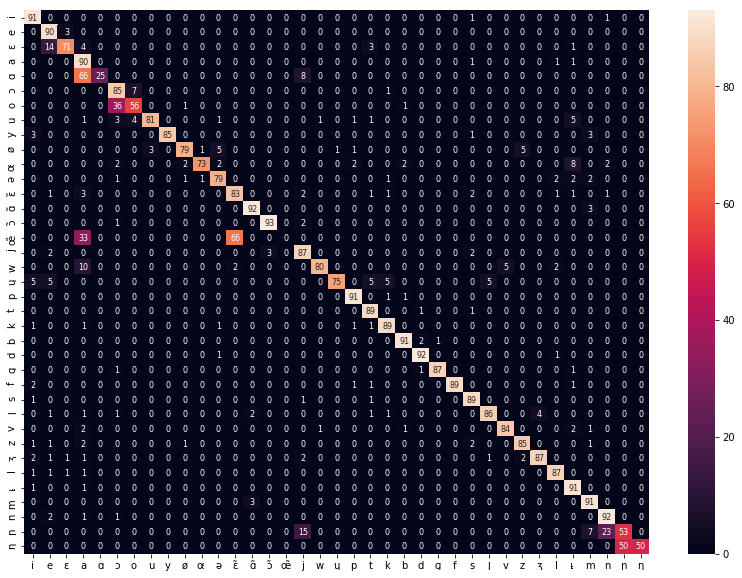

In [35]:
# create a copy of char_map without \' and <SPACE>
char_map2 = char_map.copy()
del char_map2["'"]
del char_map2["<SPACE>"]

counting_bad_cases = Counter({})

# fill a confusion matrix 
confusion_array = np.zeros((len(char_map),len(char_map)))
for i in range(len(targets)):
    target_phonemes = get_phonemes(targets[i])
    prediction_phonemes = get_phonemes(predictions[i])
    for j in range(len(target_phonemes)):
        letter_targeted = target_phonemes[j]
        if j < len(prediction_phonemes):
            letter_predicted = prediction_phonemes[j]
            letter_targeted_index = char_map[letter_targeted]
            letter_predicted_index = char_map[letter_predicted]
            try:
                confusion_array[letter_targeted_index, letter_predicted_index] += 1
            except:
                print('error target letter:%s (%s), prediction:%s, predicted letter (in %s)' %\
                (letter_targeted, targets[i], letter_predicted, predictions[i]))
            if letter_predicted != letter_targeted : 
                key = letter_predicted + '-' + letter_targeted
                counting_bad_cases[key] += 1

for t in range(confusion_array.shape[0]):
    sum = 0
    for p in range(confusion_array.shape[1]):
        sum += confusion_array[t, p]
    for p in range(confusion_array.shape[1]):
        if sum > 0:
            confusion_array[t, p] = int(confusion_array[t, p]/sum*100)
            
# display the confusion matrix
# create a copy of char map without first two chars (' and SPACE)
char_map2 = char_map.copy()
del char_map2["'"]
del char_map2["<SPACE>"]
# display the confusion matrix without first 2 rows and first 2 colums
df_cm = pd.DataFrame(confusion_array[2:,2:], index = [i for i in char_map2],
                  columns = [i for i in char_map2])
_ = plt.figure(figsize = (14,10))
_ = sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt='g')
_ = plt.show()

In [36]:
counting_bad_cases.most_common()

[('ɔ-o', 42),
 ('e-ɛ', 33),
 ('o-ɔ', 23),
 ('ɛ-e', 21),
 ('i-ʁ', 13),
 ('s-a', 12),
 ('ɑ̃-m', 11),
 ('s-i', 10),
 ('a-ɛ', 9),
 ('d-t', 9),
 ('l-a', 9),
 ('i-s', 9),
 ('a-ʁ', 8),
 ('ɔ̃-j', 8),
 ('t-ɛ', 8),
 ('n-i', 8),
 ('t-s', 8),
 ('ʁ-a', 8),
 ('m-ɑ̃', 8),
 ('a-ɑ', 8),
 ('s-t', 7),
 ('j-s', 7),
 ('i-l', 6),
 ('ʁ-i', 6),
 ('k-i', 6),
 ('z-i', 6),
 ('a-k', 6),
 ('ɛ-l', 5),
 ('ʁ-u', 5),
 ('e-j', 5),
 ('i-f', 5),
 ('e-l', 5),
 ('i-t', 5),
 ('j-i', 5),
 ('j-e', 5),
 ('p-k', 5),
 ('ʁ-t', 5),
 ('a-s', 5),
 ('s-j', 5),
 ('a-l', 5),
 ('p-t', 4),
 ('o-u', 4),
 ('d-b', 4),
 ('ɑ-a', 4),
 ('ə-k', 4),
 ('k-ɔ', 4),
 ('a-w', 4),
 ('s-z', 4),
 ('m-y', 4),
 ('a-z', 4),
 ('k-a', 4),
 ('z-s', 4),
 ('t-k', 4),
 ('t-a', 4),
 ('i-k', 4),
 ('e-n', 4),
 ('ɔ-l', 4),
 ('t-i', 4),
 ('l-ə', 4),
 ('i-y', 4),
 ('ʁ-ɛ', 4),
 ('l-d', 4),
 ('m-ə', 4),
 ('ʁ-ə', 4),
 ('m-z', 3),
 ('l-ʁ', 3),
 ('b-e', 3),
 ('a-t', 3),
 ('a-m', 3),
 ('ɔ-t', 3),
 ('f-ɔ', 3),
 ('l-i', 3),
 ('ɑ̃-s', 3),
 ('k-l', 3),
 ('t-e', 3),
 ('ɛ-k', 3),
